# "В один клик": увеличение покупательской активности клиентов

## Описание проекта

**Цель** — разработать персонализированные предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Задачи** для достижения цели:
- Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяц.
- Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Выделить сегменты покупателей и разработать для них персонализированные предложения, используя данные модели и данные о прибыльности клиентов.

**В распоряжении четыре датасета:**
- `market_file.csv`
- `market_money.csv`
- `market_time.csv`
- `money.csv`


1. Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателюдополнительные предложения о товаре. Cогласие на это дает покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего
приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

2. Файл `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.
- `Выручка` — сумма выручки за период.

3. Файл `market_time.csv` содержит данные о времени (в минутах), которое покупатель провел на сайте в течение периода.
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
- `минут` — значение времени, проведенного на сайте, в минутах.

4. Файл `money.csv` содержит данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.

## Загрузка данных и создание констант

In [1]:
# Стандартные библиотеки
import warnings


# Сторонние библиотеки
from IPython.display import display, HTML
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
from phik.report import plot_correlation_matrix
import plotly.express as px
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Глобальные настройки
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None


# Игнорирование предупреждений
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# создадим константу RANDOM_STATE
RANDOM_STATE = 42

# создадим константу TEST_SIZE
TEST_SIZE = 0.25

In [3]:
# считываем данные из csv-файлов в датафреймы и сохраняем в переменные
try:
    market_file = pd.read_csv('/datasets/market_file.csv', sep=',')
    market_money = pd.read_csv('/datasets/market_money.csv', sep=',')
    market_time = pd.read_csv('/datasets/market_time.csv', sep=',')
    money = pd.read_csv('/datasets/money.csv', sep=';')
except:
    market_file = pd.read_csv('market_file.csv', sep=',')
    market_money = pd.read_csv('market_money.csv', sep=',')
    market_time = pd.read_csv('market_time.csv', sep=',')
    money = pd.read_csv('money.csv', sep=';')

In [4]:
# сделаем копии датафреймов
market_file_df = market_file.copy()
market_money_df = market_money.copy()
market_time_df = market_time.copy()
money_df = money.copy()

In [5]:
# просматриваем по три произвольных строки в данных 

# создаем словарь: ключ — название датафрейма, значение — сам датафрейм
dataframes = {
    'market_file_df' : market_file_df,
    'market_money_df' : market_money_df,
    'market_time_df' : market_time_df,
    'money_df' : money_df
}

# выводим по три произвольных строки в каждом датафрейме
for name, df in dataframes.items():
    print(f'\033[1mДатафрейм {name}\033[0m')
    display(df.tail(3))
    print('')

Датафрейм market_file_df


id Покупательская активность Тип сервиса Разрешить сообщать  \
1297  216645           Прежний уровень    стандарт                 да   
1298  216646           Прежний уровень    стандарт                 да   
1299  216647           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
1297                 4.1                     3           586   
1298                 6.3                     5           645   
1299                 4.0                     5           906   

      Акционные_покупки            Популярная_категория  \
1297               0.20               Домашний текстиль   
1298               0.12  Техника для красоты и здоровья   
1299               0.94  Техника для красоты и здоровья   

      Средний_просмотр_категорий_за_визит  Неоплаченные_продукты_штук_квартал  \
1297                                    3                                   2   
1298                                    3                                   3   
1299                                    4                                   5   

      Ошибка_сервиса  Страниц_за_визит  
1297               5                 7  
1298               5                 7  
1299               3                12


Датафрейм market_money_df


id               Период  Выручка
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3


Датафрейм market_time_df


id            Период  минут
2597  216646     текущий_месяц      7
2598  216647     текущий_месяц     10
2599  216647  предыдцщий_месяц     15


Датафрейм money_df


id Прибыль
1297  216645    3,29
1298  216646    4,03
1299  216647    3,28

Все данные из описания присутствуют, загрузка прошла успешно. Однако разделитель десятичных значений в датафрейме `money_df` — запятая, а в остальных — точка. Приведем все разделители десятичных значений к точке.

In [6]:
# заменим ',' на '.'
money_df['Прибыль'] = money_df['Прибыль'].str.replace(',', '.')
# проверим результат замены
print('\033[1mДатафрейм money_df\033[0m')
money_df.sample(3)

Датафрейм money_df


id Прибыль
749   216097    3.82
571   215919    4.62
1025  216373    4.61

Замена разделителя десятичных значений прошла успешно.

Кроме этого приведем названия столбцов к единому стилю snake_case.

In [7]:
# приведем все названия колонок к нижнему регистру
# применим преобразование к каждому DataFrame
for df in [market_file_df, market_money_df, market_time_df, money_df]:
    df.columns = df.columns.str.lower()

# заменим пробелы в названиях датафрейма market_file_df на нижнее подчеркивание
market_file_df.columns = market_file_df.columns.str.replace(' ', '_')

In [8]:
# проверим приведение названия столбцов к единому стилю snake_case
for name, df in dataframes.items():
    print(f'\033[1mСписок признаков {name}:\033[0m')
    display(df.columns)
    print('')

Список признаков market_file_df:


Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')


Список признаков market_money_df:


Index(['id', 'период', 'выручка'], dtype='object')


Список признаков market_time_df:


Index(['id', 'период', 'минут'], dtype='object')


Список признаков money_df:


Index(['id', 'прибыль'], dtype='object')

Приведение названий столбцов к единому стилю snake_case прошло успешно.

**Промежуточные выводы**

1. Загрузка данных прошла успешно: все признаки присутствуют.
2. Разделитель дробных значений в датафрейме `money_df` приведен к точке.
3. Названия столбцов во всех датафреймах приведены к единому стилю snake_case.

Данные готовы к предобработки.

## Используемые в проекте основные собственные функции

In [9]:
# создаем функцию для создания однотипных диаграмм размаха
def build_boxplot(data, column_name, x_label, ax):
    '''
    Строит диаграмму размаха для указанной колонки данных на заданной оси.

    :param data: DataFrame с данными
    :param column_name: Название колонки, на основе которой строится диаграмма размаха
    :param x_label: Название горизонтальной оси
    :param ax: Ось, на которой строится гистограмма
    '''
    ax.boxplot(data[column_name], vert=False)
    ax.set_xlabel(x_label)

In [10]:
# создаем функцию для создания однотипных гистограмм
def build_histogram(data, column_name, x_label, num_bins, ax):
    '''
    Строит гистограмму для указанной колонки данных на заданной оси.

    :param data: DataFrame с данными
    :param column_name: Название колонки, на основе которой строится гистограмма
    :param x_label: Название горизонтальной оси
    :param num_bins: Число корзин (бинов)
    :param ax: Ось, на которой строится гистограмма
    '''
    ax.hist(data[column_name], bins=num_bins, edgecolor='black')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Частота')

In [11]:
# создаем функцию для создания однотипных столбчатых диаграмм
def build_bar_chart(data, column_name, ax=None, orientation='vertical'):
    """
    Строит столбчатую диаграмму для указанной колонки данных на заданной оси.

    :param data: DataFrame с данными
    :param column_name: Название колонки, на основе которой строится диаграмма
    :param ax: Ось, на которой строится диаграмма
    :param orientation: Ориентация диаграммы ('vertical' или 'horizontal')
    """
    if ax is None:
        ax = plt.gca() # Создаем ось, если она не задана

    counts = data[column_name].value_counts()
    
    if orientation == 'vertical':
        bars = ax.bar(counts.index, counts.values)
        ax.set_xlabel('Категории')
        ax.set_ylabel('Количество')
        ax.set_xticks(range(len(counts)))  # Устанавливаем позиции меток
        ax.set_xticklabels(counts.index, rotation=45, ha='right')  # Поворот меток на оси X
    elif orientation == 'horizontal':
        bars = ax.barh(counts.index, counts.values)
        ax.set_ylabel('Категории')
        ax.set_xlabel('Количество')
        ax.set_yticks(range(len(counts)))  # Устанавливаем позиции меток
        ax.set_yticklabels(counts.index, rotation=45, ha='right')  # Поворот меток на оси Y
    else:
        raise ValueError("Ориентация должна быть 'vertical' или 'horizontal'")

    # Добавляем числовые значения на столбцы
  #  ax.bar_label(bars, label_type='edge')

    ax.set_title(f'Столбчатая диаграмма признака {column_name}')
    ax.grid(True)  # Включаем сетку

In [12]:
# создаем функцию для создания однотипных круговых диаграмм
def build_pie_chart(data, column_name, ax=None, autopct='%1.1f%%'):
    """
    Строит круговую диаграмму для указанной колонки данных на заданной оси.

    :param data: DataFrame с данными
    :param column_name: Название колонки, на основе которой строится диаграмма
    :param ax: Ось, на которой строится диаграмма
    :param autopct: Формат отображения процентов
    """
    if ax is None:
        ax = plt.gca()

    # Подсчитываем количество каждой категории
    counts = data[column_name].value_counts()

    # Строим круговую диаграмму
    ax.pie(counts, labels=counts.index, autopct=autopct, startangle=140)

    # Устанавливаем заголовок
    ax.set_title(f'Круговая диаграмма признака {column_name}')

In [13]:
def phik_correlation_matrix(df, threshold=0.9, output_interval_cols=True):
    """
    Строит матрицу корреляции Фи-К и выводит пары признаков с корреляцией выше порога
    
    :param df: DataFrame с данными
    :param threshold: Пороговое значение корреляции (в диапазоне [0, 1])
    :param output_interval_cols: Возвращать список числовых столбцов?
    :return: DataFrame с парами признаков и их корреляцией + (опционально) список числовых столбцов
    """
    # Получение списка числовых столбцов
    interval_cols = (df
                     .select_dtypes(['number'])
                     .columns
                     .tolist()
                    )

    # Вычисление матрицы phi_k
    phik_overview = (df
                     .phik_matrix(interval_cols=interval_cols)
                     .round(2)
                    )

    # Визуализация матрицы
    plot_correlation_matrix(phik_overview.values,
                            x_labels=phik_overview.columns,
                            y_labels=phik_overview.index,
                            vmin=0, vmax=1, color_map="Greens",
                            title=r"Матрица корреляции $\phi_K$",
                            fontsize_factor=1,
                            figsize=(10, 8))
    plt.tight_layout()
    plt.show()

    # Фильтрация значений выше порога (только положительные значения, так как phi_k >=0)
    close_to_one = phik_overview[phik_overview >= threshold]

    # Удаление диагонали и нижней треугольной матрицы
    close_to_one = close_to_one.where(np.triu(np.ones(close_to_one.shape), k=1).astype(bool))

    # Преобразование в формат "длинной таблицы"
    close_to_one_stacked = close_to_one.stack().reset_index()
    close_to_one_stacked.columns = ['признак_1', 'признак_2', 'корреляция']
    close_to_one_stacked = close_to_one_stacked.dropna(subset=['корреляция'])

    # Классификация по шкале Чеддока (адаптировано для phi_k)
    def classify_correlation(corr):
        if corr >= 0.9:
            return 'Очень высокая'
        elif corr >= 0.7:
            return 'Высокая'
        elif corr >= 0.5:
            return 'Заметная'
        elif corr >= 0.3:
            return 'Умеренная'
        elif corr >= 0.1:
            return 'Слабая'
        else:
            return '-'
        
    close_to_one_stacked['класс_корреляции'] = close_to_one_stacked['корреляция'].apply(classify_correlation)

    # Сортировка по убыванию корреляции
    close_to_one_sorted = close_to_one_stacked.sort_values(
        by='корреляция', 
        ascending=False
    ).reset_index(drop=True)

    # Вывод сообщения, если нет значимых корреляций
    if len(close_to_one_sorted) == 0 and threshold >= 0.9:
        print('\033[1mМультиколлинеарность между парами входных признаков отсутствует\033[0m')

    # Возврат результатов
    if output_interval_cols:
        return close_to_one_sorted, interval_cols
    else:
        return close_to_one_sorted

In [14]:
def plot_distribution_with_boxplot(df, features, target_col):
    n_features = len(features)
    ncols = min(4, n_features) # количество столбцов в сетке графиков (не более 4)
    rows_per_feature = 2 # количество строк на каждый признак (2 строки: одна для гистограммы, другая для boxplot)
    nrows = (n_features + ncols - 1) // ncols * rows_per_feature # общее количество строк в сетке графиков

    # Создание сетки графиков
    fig, axes = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(14, 3 * nrows), 
        squeeze=False # гарантирует, что axes всегда будет двумерным массивом
    )

    # Получаем категории в нужном порядке и создаем цвета
    categories = sorted(df[target_col].unique())  # Сортируем категории для воспроизводимости
    palette = plt.cm.Paired(np.linspace(0, 1, len(categories)))
    category_to_color = {cat: color for cat, color in zip(categories, palette)}

    # Создаем элементы легенды
    legend_elements = [
        Patch(facecolor=color, label=str(cat), alpha=0.6)
        for cat, color in category_to_color.items()
    ]

    # Цикл по признакам для создания графиков
    for i, (feature_col, feature_label) in enumerate(features):
        col = i % ncols # столбец для текущего признака
        row_base = (i // ncols) * rows_per_feature # базовая строка для текущего признака

        # Гистограмма
        ax_hist = axes[row_base, col]
        sns.histplot(
            data=df,
            x=feature_col,
            hue=target_col,
            kde=True,
            multiple='stack',
            palette=category_to_color,  # Используем словарь цветов
            ax=ax_hist,
            legend=False
        )

        # Настройка гистограммы
        ax_hist.set_title(f'Распределение {feature_label}', fontsize=10)
        ax_hist.set_xlabel('')
        
        if i == 0:
            ax_hist.set_ylabel('Частота', fontsize=9)
        else:
            ax_hist.set_ylabel('')

        if i == n_features - 1:
            ax_hist.legend(
                handles=legend_elements,
                title=target_col,
                fontsize=8,
                title_fontsize=8,
                loc='upper right'
            )

        ax_hist.grid(axis='y', alpha=0.3)
        ax_hist.tick_params(axis='x', labelrotation=45)

        # Boxplot
        ax_box = axes[row_base + 1, col]
        sns.boxplot(
            data=df,
            x=feature_col,
            y=target_col,
            order=categories,  # Указываем порядок категорий
            palette=category_to_color,  # Используем тот же цвет
            orient='h',
            ax=ax_box,
            width=0.6
        )

        # Настройка Boxplot        
        if i == 0:
            ax_box.tick_params(axis='y', labelrotation=45, labelsize=8)
        else:
            ax_box.set_yticklabels([])
        
        ax_box.set_xlabel(feature_label, fontsize=9)
        ax_box.grid(axis='y', alpha=0.3)
        ax_box.tick_params(axis='x', labelrotation=45)
        ax_box.set_ylabel('')

    # Скрываем пустые оси
    for row in range(nrows):
        for col in range(ncols):
            current_idx = (row // rows_per_feature) * ncols + col
            if current_idx >= n_features:
                axes[row, col].set_visible(False)
            else:
                if row % rows_per_feature not in [0, 1]:
                    axes[row, col].set_visible(False)

    # Настройка макета и отображение графиков
    plt.tight_layout(h_pad=1.5, w_pad=1.5)
    plt.show()

In [15]:
def plot_categorical_sunburst(df, categorical_features, target_col):
    """
    Строит Sunburst-диаграммы для категориальных признаков с включением целевого признака
    
    Параметры:
    df (pd.DataFrame): Исходный датафрейм
    categorical_features (list): Список категориальных признаков для анализа
    target_col (str): Название целевого признака
    """
    for feature in categorical_features:
        # Создаем агрегированные данные
        sunburst_data = df.groupby([target_col, feature]).size().reset_index(name='count')
        
        # Строим Sunburst-диаграмму
        fig = px.sunburst(
            sunburst_data,
            path=[target_col, feature],
            values='count',
            color='count',
            color_continuous_scale='viridis',
            title=f'Связь {feature} с {target_col}'
        )
        
        # Настройка визуализации
        fig.update_layout(
            margin=dict(t=50, l=0, r=0, b=0),
            coloraxis_colorbar=dict(title='Количество'),
            font=dict(size=10)
        )
        
        # Добавляем процентные доли
        fig.update_traces(textinfo='label+percent parent')
        fig.show()

In [16]:
def vif_(X, font_size=12):
    """Строит столбчатую диаграмму с коэффициентами инфляции дисперсии (VIF) для всех входных признаков.

    Args:
        X (pd.DataFrame): DataFrame с входными признаками для анализа.
        font_size (int): Размер шрифта для текстовых элементов графика (по умолчанию 12).

    Notes:
        - Коэффициент инфляции дисперсии (VIF) показывает степень мультиколлинеарности между признаками.
        - График отображается напрямую через matplotlib.
    """
    # Кодируем категориальные признаки
    X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)
    
    # Добавляем константу для корректного расчета VIF
    X_with_const = sm.add_constant(X_encoded)
    
    # Вычисляем VIF для всех признаков, кроме константы (индексы начинаются с 1)
    vif = [variance_inflation_factor(X_with_const.values, i) 
           for i in range(1, X_with_const.shape[1])]  # Исключаем константу (0-й столбец)
    
    # Построение графика с использованием исходных названий признаков (без константы)
    num_features = X_encoded.shape[1]
    fig_width = num_features * 1.2
    fig_height = 12

    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(x=X_encoded.columns, y=vif)
    
    # Настройки графика
    ax.set_ylabel('VIF', fontsize=font_size)
    ax.set_xlabel('Входные признаки', fontsize=font_size)
    plt.title('Коэффициент инфляции дисперсии для входных признаков (VIF)', fontsize=font_size)
    
    # Метки на осях
    plt.xticks(rotation=90, ha='right', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    
    # Добавляем значения на столбцы (опционально)
    # ax.bar_label(ax.containers[0], fmt='%.2f', padding=3, fontsize=font_size)
    
    plt.tight_layout()
    plt.show()

##  Предобработка данных

Проверим данные на наличие дубликатов и пропусков. Узнаем, корректный ли тип данных у каждого признака.

Скорректируем тип данных, обработаем сначала дубликаты и наконец пропуски. Такая последовательность действий обусловлена тем, что, во-первых, мы можем избежать удаления или заполнения пропусков в записях, которые в конечном итоге будут удалены как дубликаты. Это может сэкономить вычислительные ресурсы и упростить процесс очистки данных. Во-вторых, после удаления дубликатов и корректировки типа данных, у нас останутся уникальные записи, и мы сможем более точно оценить, как обработать пропуски (например, заполнить средним значением, медианой или удалить записи с пропусками).

In [17]:
# выведем общую информацию о датафреймах
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mОбщая информация для {name}:\033[0m')
    df.info()
    print('')

Общая информация для market_file_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64 

Сразу можно отметить, что пропуски во всех датафреймах отсутствуют. Кроме того тип данных соответствует описанию для всех датафреймов кроме `money_df`. В последнем датафрейме признак `прибыль` должен иметь тип данных `float64` вместо `object`.

Исправим тип данных в датафрейме `money_df`.

In [18]:
# преобразуем тип данных с object на float64
money_df['прибыль'] = money_df['прибыль'].astype('float64')

In [19]:
# проверим результат преобразования
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Тип данных преобразован успешно.

Теперь проанализируем дубликаты во всех датафреймах.

Для начала узнаем количество явных дубликатов.

In [20]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в market_file_df: 0
Количество явных дубликатов в market_money_df: 0
Количество явных дубликатов в market_time_df: 0
Количество явных дубликатов в money_df: 0


Явные дубликаты в датафреймах отсутствуют.

Теперь проверим наличие неявных дубликатов. Для этого выведем уникальные значения всех категориальных признаков.

In [21]:
# выведем уникальные значений для каждого категориального признака каждого DataFrame
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков market_file_df:
  покупательская_активность: ['Снизилась' 'Прежний уровень']
  тип_сервиса: ['премиум' 'стандартт' 'стандарт']
  разрешить_сообщать: ['да' 'нет']
  популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Уникальные значения для признаков market_money_df:
  период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']

Уникальные значения для признаков market_time_df:
  период: ['текущий_месяц' 'предыдцщий_месяц']

Уникальные значения для признаков money_df:



Наблюдаются опечатки в категориях таких признаков как: `тип_сервиса`, `популярная_категория`, `период` в датафреймах `market_money_df` и `market_time_df` — которые могут быть источниками неявных дубликатов. Для этого исправим опечатки.

In [22]:
# проведем исправления опечатков с помощью replace()
market_file_df['тип_сервиса'] = (
    market_file_df['тип_сервиса']
    .replace('стандартт', 'стандарт')
)
market_file_df['популярная_категория'] = (
    market_file_df['популярная_категория']
    .replace('Косметика и аксесуары', 'Косметика и аксессуары')
)
market_money_df['период'] = (
    market_money_df['период']
    .replace('препредыдущий_месяц', 'предыдущий_месяц')
)
market_time_df['период'] = (
    market_time_df['период']
    .replace('предыдцщий_месяц', 'предыдущий_месяц')
)

Проверим исправления опечатков.

In [23]:
# выведем уникальные значений для каждого категориального признака каждого DataFrame
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mУникальные значения для признаков {name}:\033[0m')
    for column in df.select_dtypes(include='object').columns:
        unique_values = df[column].unique()
        print(f'  \033[1m{column}:\033[0m {unique_values}')
    print('')

Уникальные значения для признаков market_file_df:
  покупательская_активность: ['Снизилась' 'Прежний уровень']
  тип_сервиса: ['премиум' 'стандарт']
  разрешить_сообщать: ['да' 'нет']
  популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксессуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']

Уникальные значения для признаков market_money_df:
  период: ['предыдущий_месяц' 'текущий_месяц']

Уникальные значения для признаков market_time_df:
  период: ['текущий_месяц' 'предыдущий_месяц']

Уникальные значения для признаков money_df:



Опечатки исправлены корректно. Проверим не появились ли дубликаты.

In [24]:
# выведем количество дубликатов в каждом датафрейме
# воспользуемся items() и словарем dataframes для обращения к каждому датафрейму в цикле
for name, df in dataframes.items():
    print(f'\033[1mКоличество явных дубликатов в {name}: {df.duplicated().sum()}\033[0m')

Количество явных дубликатов в market_file_df: 0
Количество явных дубликатов в market_money_df: 5
Количество явных дубликатов в market_time_df: 0
Количество явных дубликатов в money_df: 0


Появились дубликаты в датафрейме `market_money_df`. Удалим их.

In [25]:
# удалим дубликаты в market_money_df
market_money_df = (
    market_money_df
    .drop_duplicates()
    .reset_index(drop=True)
                  )

In [26]:
# выведем количество дубликатов в market_money_df
market_money_df.duplicated().sum()

0

Удаление дубликатов прошло успешно.

**Выводы по предобработке данных**

1. Пропуски в данных отсутствуют.
2. Тип данных некорректный только в датафрейме `money_df`: в признаке `прибыль` тип данных преобразован из `object` в `float64`.
3. Классы в категориальных признаках имели опечатки, исправление которых выявило явные дубликаты.
4. Явные дубликаты обнаружены только в датафрейме `market_money_df` — удалены.

Датафреймы готовы для анализа.

## Исследовательский анализ

Проведем статистический анализ всех признаков.

### Датафрейм market_file_df

In [27]:
## просмотрим числовое описание данных market_file_df

# создадим таблицу с числовым описанием данных
pivot_market_file_df = market_file_df.describe(include='all')

# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_market_file_df.loc['rel_std%'] = pivot_market_file_df.loc['std']/pivot_market_file_df.loc['mean']*100
# добавим долю наиболее популярного класса в категориальных признаках в процентах,
# чтобы оценить дисбаланс целевого класса
pivot_market_file_df.loc['cat_top_ratio%'] = pivot_market_file_df.loc['freq']/pivot_market_file_df.loc['count']*100

# округлим числовое описание данных до сотых, транспонируем для улучшения восприятия и выведем результат
#print('\033[1mЧисловое описание данных market_file_df\033[0m')
#display(pivot_market_file_df.round(2).T)

# преобразуем в HTML
styled_table = pivot_market_file_df.round(2).T.to_html()

print('\033[1mЧисловое описание данных market_file_df\033[0m')
HTML(styled_table)

Числовое описание данных market_file_df


На основе числового описания данных `market_file_df` можно констатировать следующее:

1. `Покупательская активность` находится в основном на прежнем уровне (62%), `тип сервиса` преимущественно стандарт (71%), `согласие на рассылку` одобрили 74% и наиболее `популярная категория` из шести — товары для детей (25%). Важно отметить, что целевой бинарный признак `покупательская_активность` имеет некоторый дисбаланс, что нужно будет иметь ввиду при настройке модели машинного обучения.
2. Медианные и средние значения числовых признаков достаточно близки друг к другу, что говорит о том, что данные распределены симметрично по "весу" относительно медианного значения. Среди всех по сравнению медианного и среднего выделяется признак `акционные_покупки`, у которого среднее значение больше медианного в 1.33 раз, что указывает на некоторое влияние выбросов и/или аномалий, которые имеют большие значения.
3. Относительное стандартное отклонение, которое характеризует разброс данных и является стандартным отклонением в процентном соотношении от медианного значения, для всех числовых признаков имеет достаточно большое значение, чтобы сделать предположение, о том, что все числовые признаки могут вносить некий вклад в предсказательную способность модели (в случае корреляции с целевым признаком). Опять же по этому показателю лидирует признак — `акционные_покупки`.

Далее рассмотрим категориальные и количественные данные раздельно с помощью графиков. Начнем с количественных данных. Отобразим диаграммы размаха для непрерывных признаков, чтобы продемонстрировать как расположены данные и их разброс.

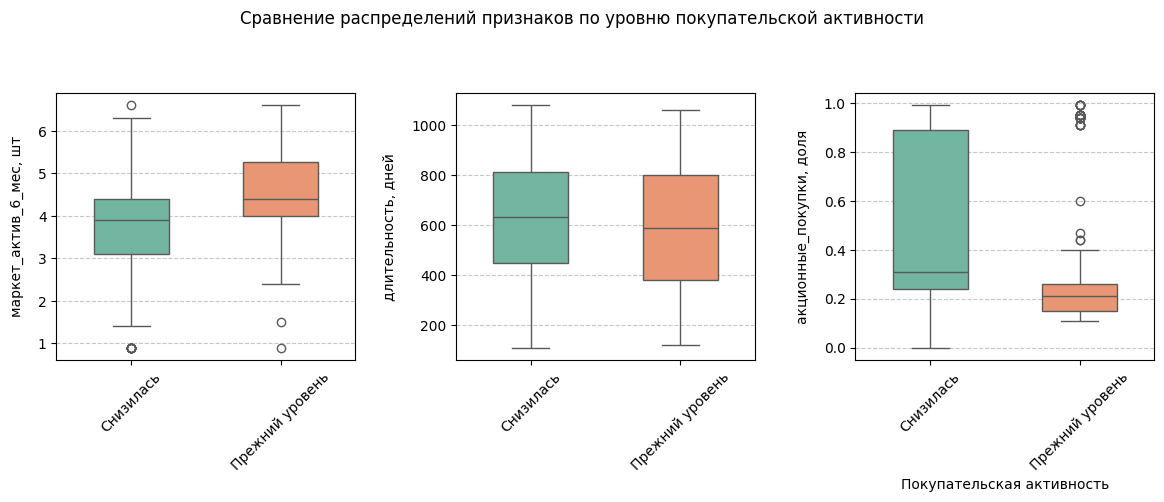

In [28]:
# Создаем фигуру и сетку подграфиков (3 строки, 1 столбец)
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Список признаков для визуализации
features = [
    ('маркет_актив_6_мес', 'маркет_актив_6_мес, шт'),
    ('длительность', 'длительность, дней'),
    ('акционные_покупки', 'акционные_покупки, доля')
]

# Строим диаграммы размаха с разделением по активности
for idx, (col, ylabel) in enumerate(features):
    ax = axs[idx]  # Выбираем соответствующую ось
    sns.boxplot(
        data=market_file_df,
        x='покупательская_активность',
        y=col,
        orient='v',
        ax=ax,
        palette='Set2',
        width=0.5
    )
    
    ax.set_xlabel('')  # Скрываем подпись оси X для всех, кроме последнего графика
    if idx == len(features)-1:
        ax.set_xlabel('Покупательская активность', fontsize=10)
    
    ax.set_ylabel(ylabel, rotation=90, labelpad=10, fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.tick_params(axis='x', labelrotation=45)  # Поворот меток оси X

# Настройка компоновки
plt.suptitle('Сравнение распределений признаков по уровню покупательской активности', 
             fontsize=12, y=1.02)
plt.tight_layout(pad=2.0, h_pad=2.5)
plt.show()

Диаграммы размаха продемонстрировали выбросы в таких признаках как `маркет_актив_6_мес` и `акционные_покупки`. При этом значения не аномальные, поэтому оставим их в датафрейме, поскольку выбросы это редкие события, которые могут быть важны и в целом улучшить метрики модели. Также мы наблюдаем отличия в распределениях `маркет_актив_6_мес` и `акционные_покупки` для разных классов целевого признака. Для распределения `маркет_актив_6_мес` мы наблюдаем больше значения этого признака для класса `Прежний уровень`. Для распределения `акционные_покупки` мы наблюдаем два пика именно для клиентов с классом `Прежний уровень` вблизи значений: 0.2, 0.9.

Построим гистограммы для непрерывных признаков и столбчатые диаграммы для дискретных для продолжения статистического анализа, чтобы выяснить как для каждого признака данные распределены между собой.

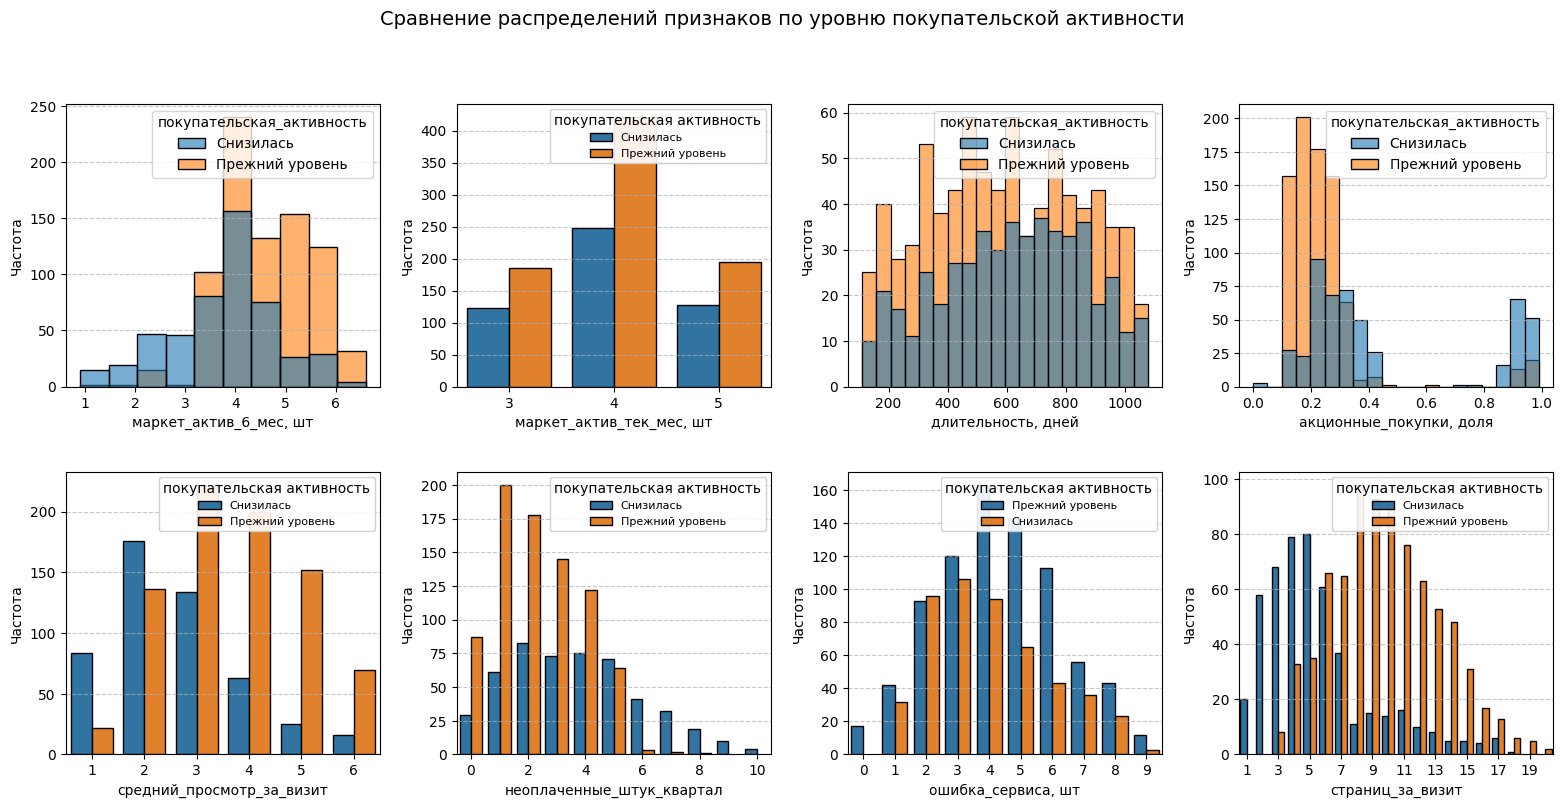

In [29]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

# Список признаков для визуализации
features = [
    ('маркет_актив_6_мес', 'маркет_актив_6_мес, шт', 10),
    ('маркет_актив_тек_мес', 'маркет_актив_тек_мес, шт', None),
    ('длительность', 'длительность, дней', 20),
    ('акционные_покупки', 'акционные_покупки, доля', 20),
    ('средний_просмотр_категорий_за_визит', 'средний_просмотр_за_визит', None),
    ('неоплаченные_продукты_штук_квартал', 'неоплаченные_штук_квартал', None),
    ('ошибка_сервиса', 'ошибка_сервиса, шт', None),
    ('страниц_за_визит', 'страниц_за_визит', None)
]

# Строим графики
for idx, (col, xlabel, bins) in enumerate(features):
    ax = axs[idx//4, idx%4]
    if bins:  # Для числовых признаков
        sns.histplot(data=market_file_df, x=col, hue='покупательская_активность', 
                     multiple='layer', bins=bins, edgecolor='black', 
                     alpha=0.6, ax=ax)
    else:  # Для категориальных признаков
        sns.countplot(data=market_file_df, x=col, hue='покупательская_активность', 
                      edgecolor='black', ax=ax)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both')) # для автоматической настройки промежутков между метками
    
    # Добавляем легенду только если есть данные для разделения
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles, labels, title='покупательская активность', prop={'size': 8}, 
                  frameon=True, framealpha=0.9)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Частота')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Настройка компоновки
plt.suptitle('Сравнение распределений признаков по уровню покупательской активности', 
             fontsize=14, y=1.02)
plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=1.5)
plt.show()

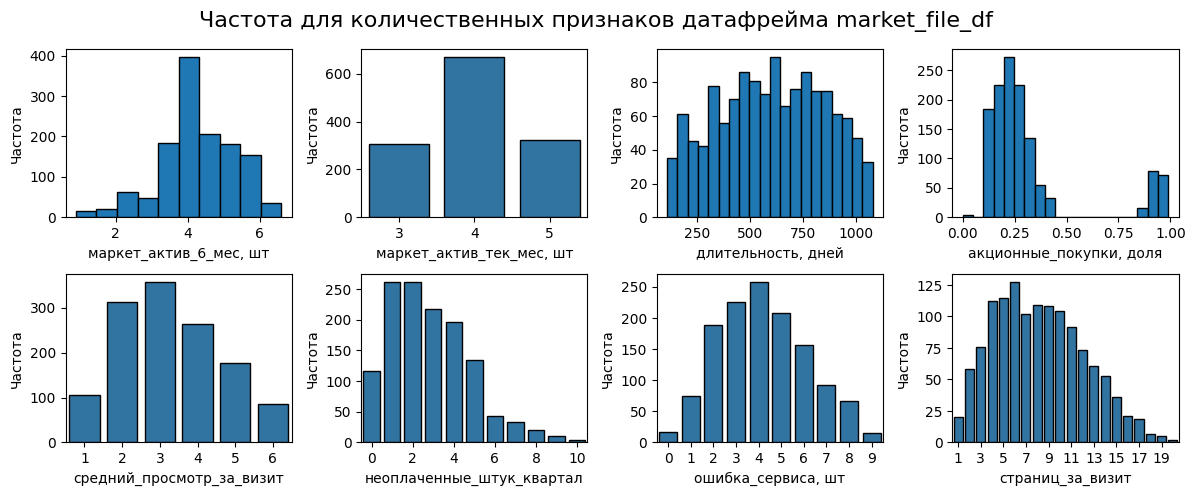

In [30]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(2, 4, figsize=(12, 5))

# Строим подграфики
build_histogram(market_file_df, 'маркет_актив_6_мес', 'маркет_актив_6_мес, шт', 10, axs[0, 0])
sns.countplot(x=market_file_df['маркет_актив_тек_мес'], ax=axs[0, 1], edgecolor='black')
build_histogram(market_file_df, 'длительность', 'длительность, дней', 20, axs[0, 2])
build_histogram(market_file_df, 'акционные_покупки', 'акционные_покупки, доля', 20, axs[0, 3])
sns.countplot(x=market_file_df['средний_просмотр_категорий_за_визит'], ax=axs[1, 0], edgecolor='black')
sns.countplot(x=market_file_df['неоплаченные_продукты_штук_квартал'], ax=axs[1, 1], edgecolor='black')
sns.countplot(x=market_file_df['ошибка_сервиса'], ax=axs[1, 2], edgecolor='black')
sns.countplot(x=market_file_df['страниц_за_визит'], ax=axs[1, 3], edgecolor='black')

# Автоматическая настройка меток на оси x
axs[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
axs[1, 2].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))
axs[1, 3].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))


# Изменение названия оси x
axs[0, 1].set_xlabel('маркет_актив_тек_мес, шт')
axs[1, 0].set_xlabel('средний_просмотр_за_визит')
axs[1, 1].set_xlabel('неоплаченные_штук_квартал')
axs[1, 2].set_xlabel('ошибка_сервиса, шт')

# Изменение названия оси y
axs[0, 1].set_ylabel('Частота')
axs[1, 0].set_ylabel('Частота')
axs[1, 1].set_ylabel('Частота')
axs[1, 2].set_ylabel('Частота')
axs[1, 3].set_ylabel('Частота')

# Добавляем общее название для фигуры
fig.suptitle('Частота для количественных признаков датафрейма market_file_df', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(pad=1.0)

# Отображаем графики
plt.show()

На основе гистограмм можно отметить следующее. Распределние признака `маркет_актив_6_мес` имеет пиковое значение вблизи 4, спад влево более резкий, чем вправо. Распределение признака `маркет_актив_тек_мес` имеет три значения: с превалирующим значением 4 и практически одинаковой долей значений 3 и 5. Признак `длительность` достаточно равномерно распределен на всем промежутке значений: распределение незначительно спадает влево и вправо относительно пикового значения в области 600-650 дней. Распределение признака `акционные_покупки` имеет два пика: максимальный в районе 0.20-0.25 и побочный вблизи 0.9. Оставшиеся признаки — `средний_просмотр_категорий_за_визит`, `неоплаченные_продукты_штук_квартал`, `ошибка_сервиса`, `страниц_за_визит` — имеют куполообразные распределения с более продолжительным правым хвостом и пиковыми значениями вблизи: 3, 1.0-2.5, 4, 5.5-6.0 соответственно.

По мимо всего выше описанного и результатов, полученных с помощью построения ящиков с усами, можно добавить следующее. Распределение признака `длительность` для разных классов целевого признака одинаковое. Средний просмотр страницы для клиентов с пониженной активностью уменьшился. Среди клиентов с пониженной активностью стали проявляться клиенты, у которых количество неоплаченных товаров в квартал стало выше 6 шт. Ошибок сервиса примерно одинаково для разных классов целевого признака. Наконец, видна существенная разница в количестве страниц за визит: у клиентов с пониженной активностью данный показатель ниже, примерно в два раза.

Далее переходим к категориальным данным, для статистического анализа которых будем использовать столбчатую и круговую диаграммы.

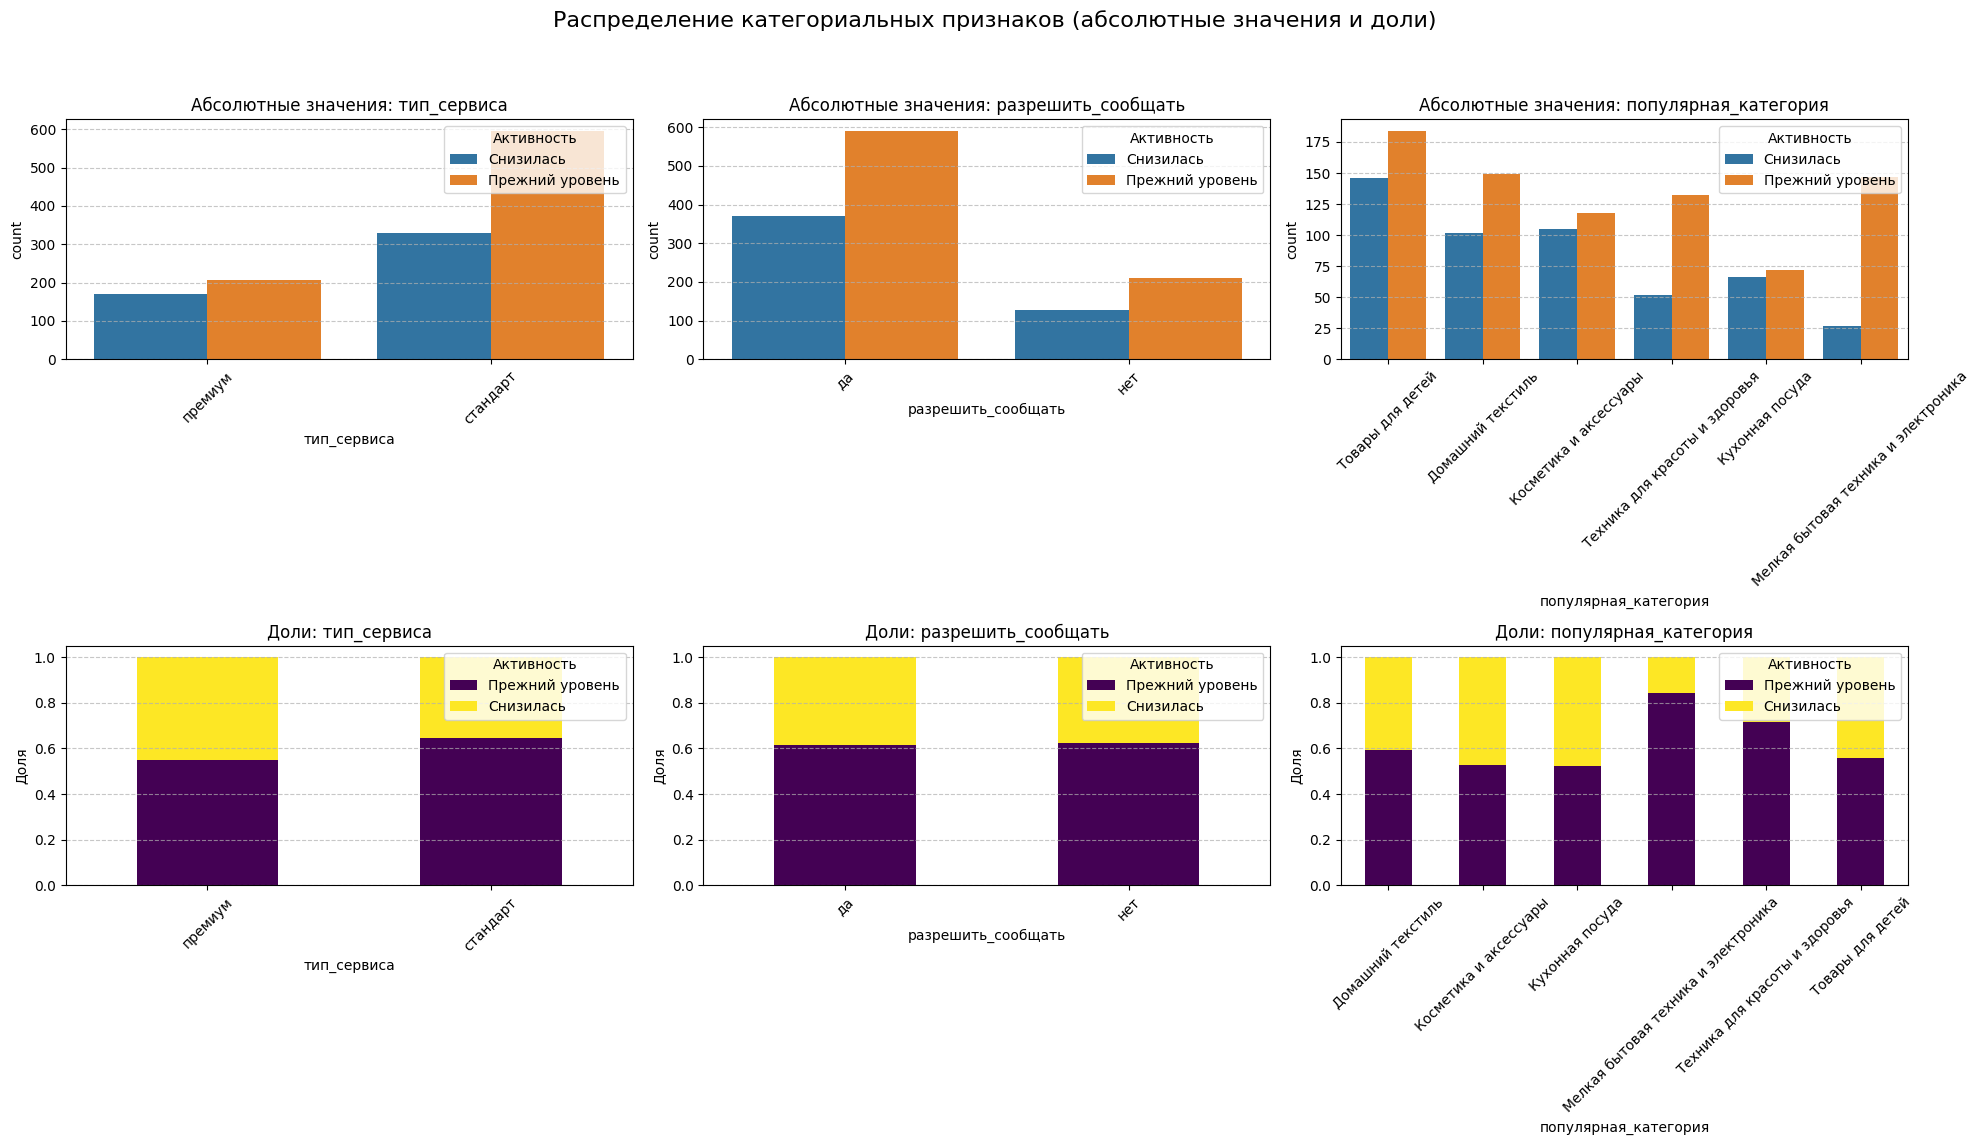

In [31]:
# Определяем категориальные признаки (исключая целевой)
categorical_features = ['тип_сервиса', 'разрешить_сообщать', 'популярная_категория']

# Создаем фигуру с 2 строки и 3 столбца
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Распределение категориальных признаков (абсолютные значения и доли)', fontsize=16)

# Настройка общего внешнего вида
plt.rcParams.update({'font.size': 10})

for i, feature in enumerate(categorical_features):
    # Верхний ряд - абсолютные значения
    sns.countplot(
        data=market_file_df,
        x=feature,
        hue='покупательская_активность',
        ax=axs[0, i]
    )
    axs[0, i].set_title(f'Абсолютные значения: {feature}')
    axs[0, i].tick_params(axis='x', rotation=45)
    axs[0, i].legend(title='Активность', loc='upper right')
    axs[0, i].grid(axis='y', linestyle='--', alpha=0.7)
    
    # Нижний ряд - нормализованные доли
    grouped = (market_file_df
               .groupby([feature, 'покупательская_активность'])
               .size()
               .unstack(fill_value=0)
               .apply(lambda x: x/x.sum(), axis=1))
    
    grouped.plot(
        kind='bar',
        stacked=True,
        ax=axs[1, i],
        colormap='viridis'
    )
    axs[1, i].set_title(f'Доли: {feature}')
    axs[1, i].tick_params(axis='x', rotation=45)
    axs[1, i].set_ylabel('Доля')
    axs[1, i].legend(title='Активность', loc='upper right')
    axs[1, i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

По распределению по целевому признаку можно отметить следующее. Клиенты с пониженной активностью преимущественно в категории премиум. Для клиентов с прежней активностью наиболее популярной категорией является техника.

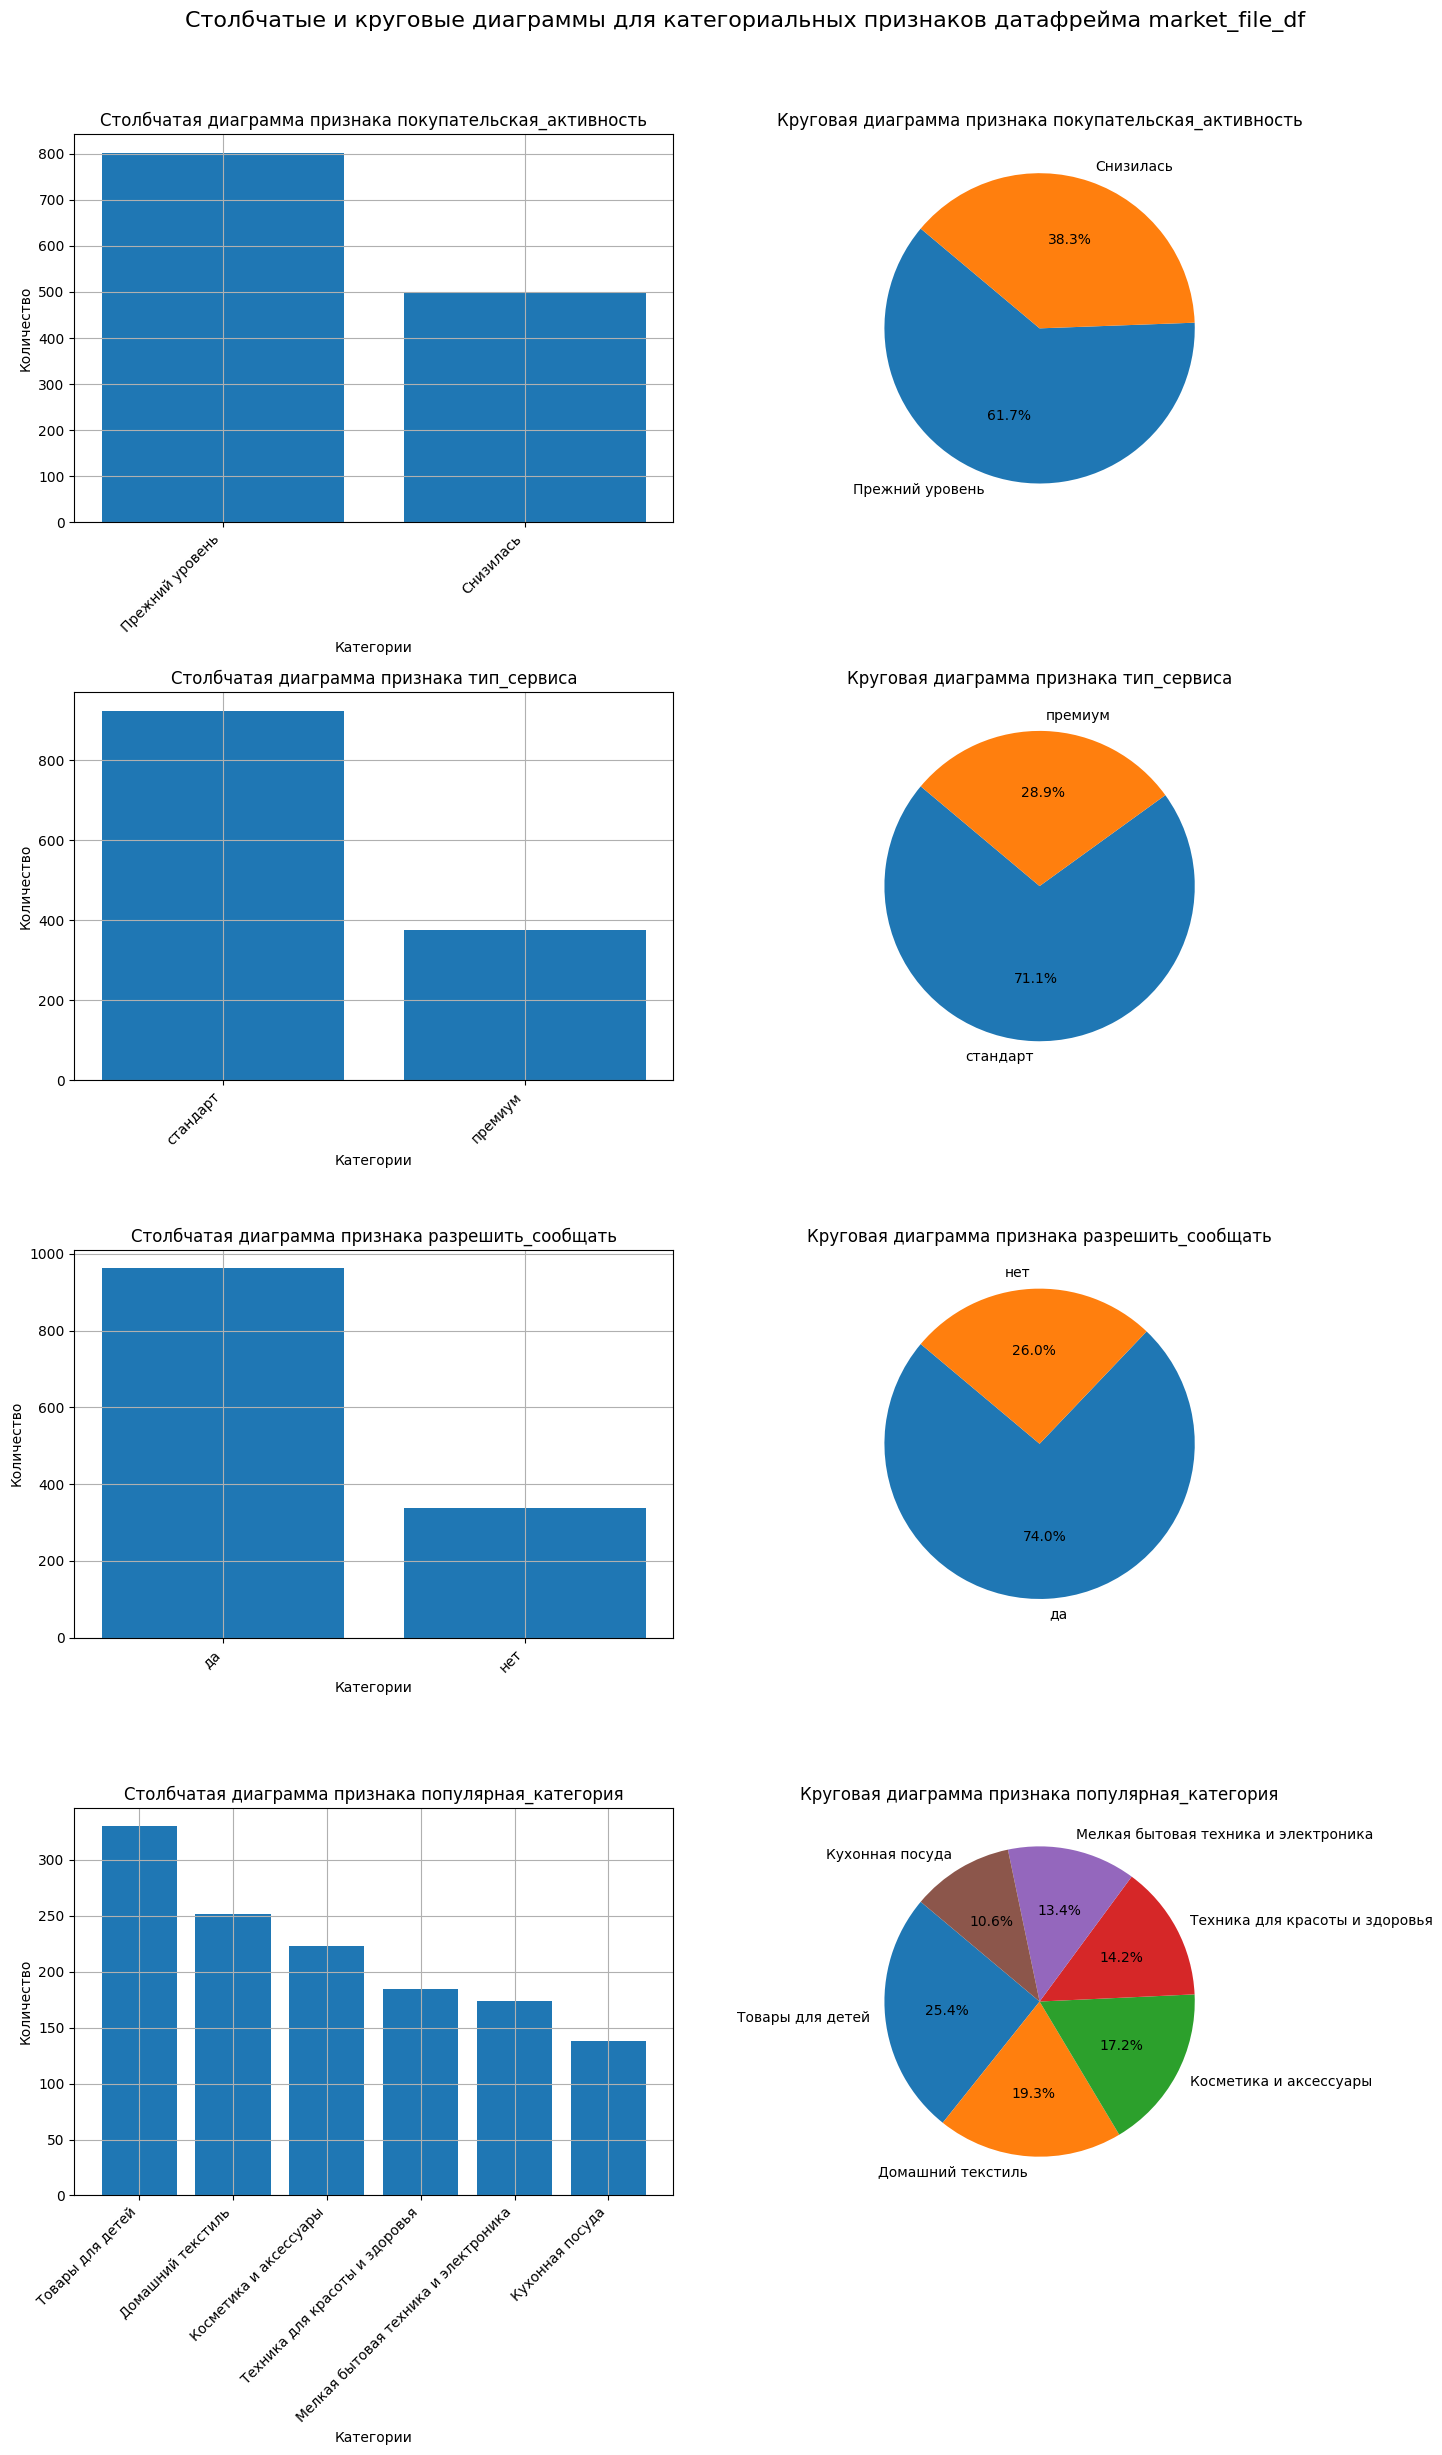

In [32]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(4, 2, figsize=(15, 25))

# Строим диаграммы
build_bar_chart(market_file_df, 'покупательская_активность', orientation='vertical', ax=axs[0, 0])
build_pie_chart(market_file_df, 'покупательская_активность', ax=axs[0, 1])
build_bar_chart(market_file_df, 'тип_сервиса', orientation='vertical', ax=axs[1, 0])
build_pie_chart(market_file_df, 'тип_сервиса', ax=axs[1, 1])
build_bar_chart(market_file_df, 'разрешить_сообщать', orientation='vertical', ax=axs[2, 0])
build_pie_chart(market_file_df, 'разрешить_сообщать', ax=axs[2, 1])
build_bar_chart(market_file_df, 'популярная_категория', orientation='vertical', ax=axs[3, 0])
build_pie_chart(market_file_df, 'популярная_категория', ax=axs[3, 1])

# Добавляем общее название для фигуры
fig.suptitle('Столбчатые и круговые диаграммы для категориальных признаков датафрейма market_file_df', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Отображаем графики
plt.show()

По факту мы визуализировали то, что ранее было зафиксировано при числовом описании данных. Что является примечательным в представленных результатах, так это то, что мы наглядно продемонстрировали как меняется популярность по категориям товаров: от товаров для детей до кухонной посуды.

### Датафрейм market_money_df

In [33]:
## просмотрим числовое описание данных market_money_df

# создадим таблицу с числовым описанием данных
pivot_market_money_df = market_money_df.describe(include='all')

# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_market_money_df.loc['rel_std%'] = pivot_market_money_df.loc['std']/pivot_market_money_df.loc['mean']*100
# добавим долю наиболее популярного класса в категориальных признаках в процентах,
# чтобы оценить дисбаланс целевого класса
pivot_market_money_df.loc['cat_top_ratio%'] = pivot_market_money_df.loc['freq']/pivot_market_money_df.loc['count']*100

# округлим числовое описание данных до сотых, транспонируем для улучшения восприятия и выведем результат
print('\033[1mЧисловое описание данных market_money_df\033[0m')
display(pivot_market_money_df.round(2).T)

Числовое описание данных market_money_df


count unique               top  freq       mean      std       min  \
id       3895.0    NaN               NaN   NaN  215997.98   375.14  215348.0   
период     3895      2  предыдущий_месяц  2595        NaN      NaN       NaN   
выручка  3895.0    NaN               NaN   NaN    5029.71  1773.33       0.0   

              25%       50%       75%       max rel_std% cat_top_ratio%  
id       215673.0  215998.0  216323.0  216647.0     0.17            NaN  
период        NaN       NaN       NaN       NaN      NaN      66.623877  
выручка    4591.4    4959.0    5363.2  106862.2    35.26            NaN

Числовое описание указывает на то, что наиболее часто встречающийся класс признака `период` — `предыдущий_месяц` (67%). Что касается числового признака `выручка`, то мы видим сильно отличающиеся минимальные и максимальные значения примерно на 5 межквартильных размаха относительно среднего значения и близкого к нему медианнного, что указывает на наличие выбросов и аномальных значений. Близкие друг к другу среднее и мединное значения, а также большое значение относительного стандартного отклонения — 35% — говорят об одинаковом влиянии выбросов и аномальных значений с одной и с другой стороны от центра распределения.

Рассмотрим количественный признак детальнее.

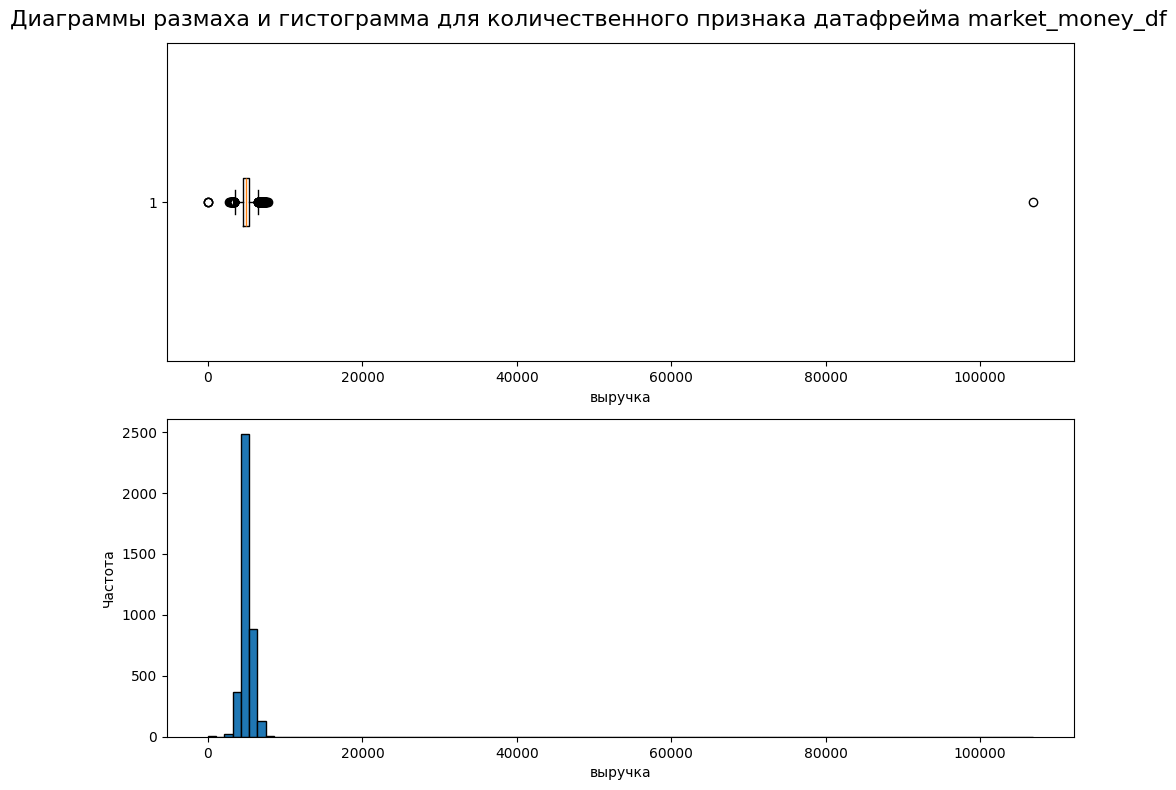

In [34]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Строим диаграммы размаха
build_boxplot(market_money_df, 'выручка', 'выручка', axs[0])
build_histogram(market_money_df, 'выручка', 'выручка', 100, axs[1])


# Добавляем общее название для фигуры
fig.suptitle('Диаграммы размаха и гистограмма для количественного признака датафрейма market_money_df', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(pad=1.0)

# Отображаем графики
plt.show()

Присутствуют аномальные значения: нулевые и больше 10000. Узнаем их количество.

In [35]:
# узнаем количество нулевых значений
print(f'кол-во нулевых значений: {(market_money_df["выручка"]==0).sum()}')

кол-во нулевых значений: 3


In [36]:
# узнаем количество аномально больших значений
print(f'кол-во аномально больших значений: {(market_money_df["выручка"]>100000).sum()}')

кол-во аномально больших значений: 1


Количество аномальных значений незначительно — 4. Такое незначительное количество данных можно удалить без вреда для статистики. Однако перед этим требуется проанализировать смысл этих данных. Аномально большое значение сильно выбивается среди всех остальных примерно на два порядка и говорит либо об ошибке при сборе данных, либо о том, что действительно один из клиентов потратил в одном из периодов такую сумму. В последнем случае это чрезвычайно редкое выделяющееся событие, которое может отрицательно повлиять на предсказательную способность модели и от него лучше избавиться. Что касается нулевых значений, то в них нет ничего необычного, так как клиент мог купить в одном периоде товар, а в другом нет.

Найдем `id` клиента с аномально большой выручкой.

In [37]:
# запишем id клиента с аномально большой выручкой
id_max = market_money_df.loc[market_money_df['выручка'].idxmax(), 'id']
print(f'id клиент с аномально большой выручкой за один из периодов: {id_max}')

id клиент с аномально большой выручкой за один из периодов: 215380


Установим `id` клиентов с нулевой выручкой.

In [38]:
# создадим списко id клиентов с нулевой выручкой хотя бы за один из периодов
id_0 = list(market_money_df.query('выручка==0')['id'])
print(f'id клиентов с нулевой выручкой за один из периодов: {id_0}')

id клиентов с нулевой выручкой за один из периодов: [215348, 215357, 215359]


In [39]:
# объединим все id клиентов с нулевой и аномально большой выручкой
id_anomaly = id_0.copy()
id_anomaly.append(id_max)

In [40]:
# используем полученный список id, чтобы выяснить выручку таких клиентов за оба периода
print('\033[1mТаблица с выручкой клиентов, у которых хотя бы за один из периодов отсутсвовали покупки, за оба периода\033[0m')
market_money_df[market_money_df['id'].isin(id_anomaly)]

Таблица с выручкой клиентов, у которых хотя бы за один из периодов отсутсвовали покупки, за оба периода


id            период   выручка
0   215348  предыдущий_месяц       0.0
1   215348     текущий_месяц    3293.1
26  215357     текущий_месяц    5986.3
27  215357  предыдущий_месяц       0.0
31  215359     текущий_месяц    4735.0
32  215359  предыдущий_месяц       0.0
93  215380  предыдущий_месяц    5051.0
94  215380  предыдущий_месяц    6077.0
95  215380     текущий_месяц  106862.2

Предположение подтвердилось: клиенты с нулевой выручкой это клиенты, у которых нулевая выручка только за один период. Для аномально большой выручки действительно могла быть опечатка и первые две цифры в значении выручки могут не относится к реальному значению. Однако проще клиента с таким `id` удалить из датасетов.

In [41]:
# удалим из всех датасетов клиента с аномально большой выручкой
market_file_df = (market_file_df
                  .drop(market_file_df.query('id==@id_max').index)
                  .reset_index(drop=True)
                 )
market_money_df = (market_money_df
                   .drop(market_money_df.query('id==@id_max').index)
                   .reset_index(drop=True)
                  )
market_time_df = (market_time_df
                  .drop(market_time_df.query('id==@id_max').index)
                  .reset_index(drop=True)
                 )
money_df = (money_df
            .drop(money_df.query('id==@id_max').index)
            .reset_index(drop=True)
           )

In [42]:
# делим датафрейм market_money_df по периоду: предыдущий и текущий
market_money_df_pivot = pd.pivot_table(market_money_df, values='выручка', index='id', columns='период', aggfunc='sum')
# проверяем деление
market_money_df_pivot.head()

период  предыдущий_месяц  текущий_месяц
id                                     
215348               0.0         3293.1
215349            9688.0         4971.6
215350           10283.5         5058.4
215351           10951.0         6610.4
215352           10401.5         5872.5

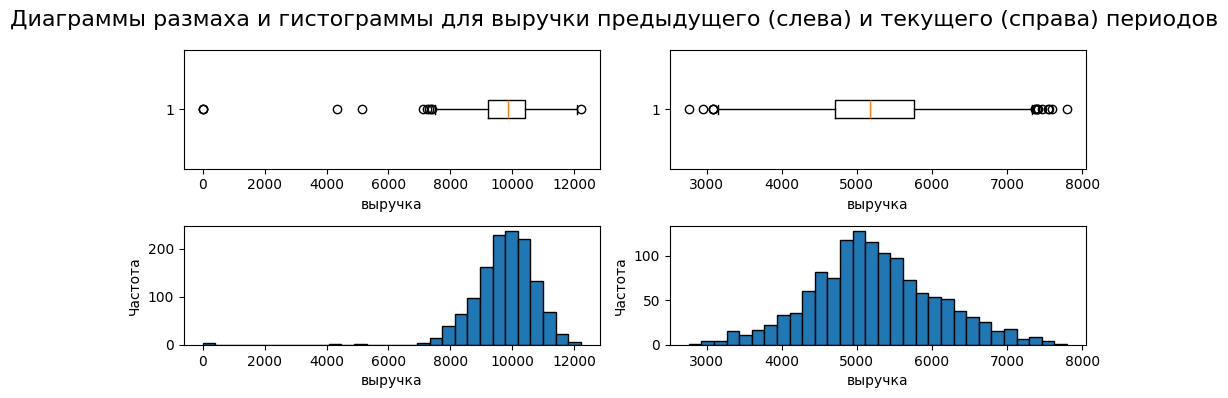

In [43]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(2, 2, figsize=(10, 4))

# Строим диаграммы размаха
build_boxplot(market_money_df_pivot, 'предыдущий_месяц', 'выручка', axs[0, 0])
build_boxplot(market_money_df_pivot, 'текущий_месяц', 'выручка', axs[0, 1])
build_histogram(market_money_df_pivot, 'предыдущий_месяц', 'выручка', 30, axs[1, 0])
build_histogram(market_money_df_pivot, 'текущий_месяц', 'выручка', 30, axs[1, 1])


# Добавляем общее название для фигуры
fig.suptitle('Диаграммы размаха и гистограммы для выручки предыдущего (слева) и текущего (справа) периодов', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(pad=1.0)

# Отображаем графики
plt.show()

По диаграммам видно, что распределение похоже на нормальное. Диаграмма размаха указывает на наличие выбросов как с одной, так и с другой стороны от центра распределения. Наблюдаем, что для текущего периода выручка спала: медианное значение уменьшилось, примерно, в 2 раза.

Рассчитаем как изменилось относительное стандартное отклонение после удаления аномально большого значения.

In [44]:
# вывод относительного стандартного отклонения для выручки
print(f'Относительное стандартное отклонение выручки: {round(market_money_df["выручка"].std()/market_money_df["выручка"].median()*100, 2)}')

Относительное стандартное отклонение выручки: 13.99


Значение 14% для относительного стандартного отклонения, учитывая симметричное распределение выбросов относительно медианы, приемлимо. С одной стороны указывает на достаточно широкий диапазон значений для возможной зависимости с целевым признаком (корреляцию между ними еще предстоит оценить), что хорошо подготовит модель к рабочим данным. С другой стороны это достаточно небольшое значение, чтобы удалять выбросы, так как в противном случае мы потеряем ценные данные и модель будет плохо подготовлена к реальным изменчивым условиям. **Вывод: выбросы оставляем.**

Перейдем к категориальному признаку.

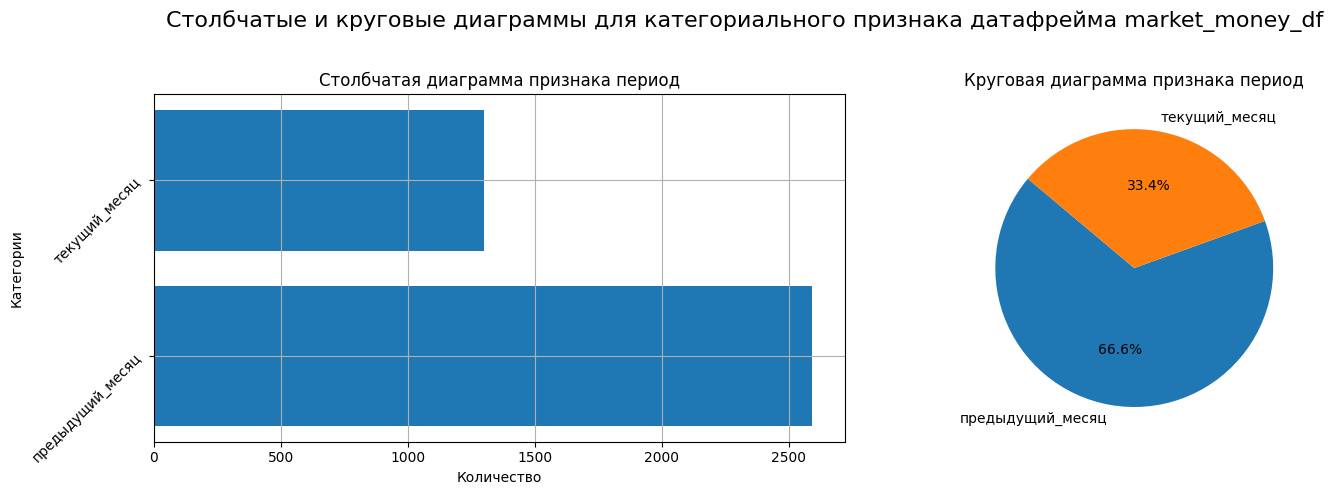

In [45]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Строим диаграммы
build_bar_chart(market_money_df, 'период', orientation='horizontal', ax=axs[0])
build_pie_chart(market_money_df, 'период', ax=axs[1])

# Добавляем общее название для фигуры
fig.suptitle('Столбчатые и круговые диаграммы для категориального признака датафрейма market_money_df', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Отображаем графики
plt.show()

Визуализация распределения категориального признака `период` прошла успешно. Мы наблюдаем, как и ранее заметили при числовом описании, что превалирует категория `предыдущий_месяц` — 67% клиентов имеют такой класс. 

### Датафрейм market_time_df

In [46]:
## просмотрим числовое описание данных market_time_df

# создадим таблицу с числовым описанием данных
pivot_market_time_df = market_time_df.describe(include='all')

# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_market_time_df.loc['rel_std%'] = pivot_market_time_df.loc['std']/pivot_market_time_df.loc['mean']*100
# добавим долю наиболее популярного класса в категориальных признаках в процентах,
# чтобы оценить дисбаланс целевого класса
pivot_market_time_df.loc['cat_top_ratio%'] = pivot_market_time_df.loc['freq']/pivot_market_time_df.loc['count']*100

# округлим числовое описание данных до сотых, транспонируем для улучшения восприятия и выведем результат
print('\033[1mЧисловое описание данных market_time_df\033[0m')
display(pivot_market_time_df.round(2).T)

Числовое описание данных market_time_df


count unique            top  freq       mean    std       min  \
id      2598.0    NaN            NaN   NaN  215997.98  375.1  215348.0   
период    2598      2  текущий_месяц  1299        NaN    NaN       NaN   
минут   2598.0    NaN            NaN   NaN      13.34   4.08       4.0   

              25%       50%        75%       max rel_std% cat_top_ratio%  
id      215673.25  215998.0  216322.75  216647.0     0.17            NaN  
период        NaN       NaN        NaN       NaN      NaN           50.0  
минут        10.0      13.0       16.0      23.0    30.61            NaN

Мы наблюдаем, что данные поровну поделены на категории признака `период`. Вероятно, для каждого пользователя с конкретным id два значения: за предыдущий и текущий периоды. Признак `минут` имеет близкие значения среднего и медианного. Учитывая нахождение максимального и минимального значений в диапазоне минус 1.5 межквартильного размаха и плюс 1.5 межквартильного размаха от 25-ти и 75-ти процентного квартилей соответственно, то аномальные значения и выбросы отсутствуют, а распределение должно быть куполообразным, похожим на нормальное.

In [47]:
# делим датафрейм market_time_df по периоду: предыдущий и текущий
market_time_df_pivot = pd.pivot_table(market_time_df, values='минут', index='id', columns='период', aggfunc='sum')
# проверяем деление
market_time_df_pivot.head()

период  предыдущий_месяц  текущий_месяц
id                                     
215348                13             14
215349                12             10
215350                 8             13
215351                11             13
215352                 8             11

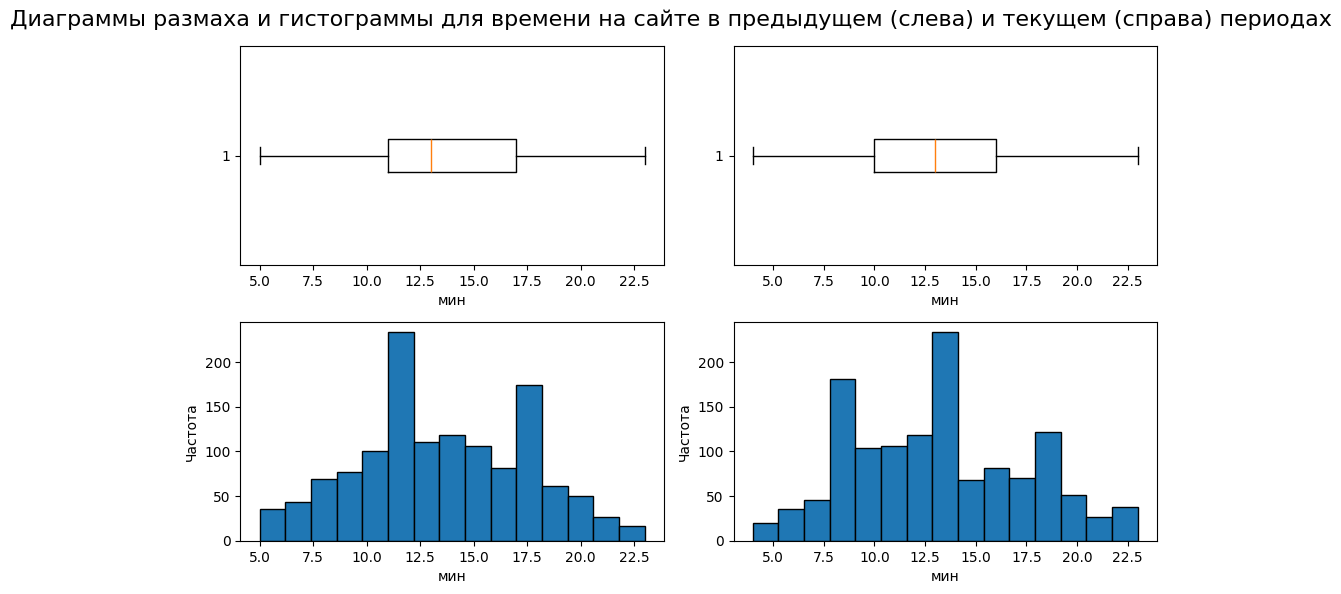

In [48]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Строим подграфики
build_boxplot(market_time_df_pivot, 'предыдущий_месяц', 'мин', axs[0, 0])
build_boxplot(market_time_df_pivot, 'текущий_месяц', 'мин', axs[0, 1])
build_histogram(market_time_df_pivot, 'предыдущий_месяц', 'мин', 15, axs[1, 0])
build_histogram(market_time_df_pivot, 'текущий_месяц', 'мин', 15, axs[1, 1])


# Добавляем общее название для фигуры
fig.suptitle('Диаграммы размаха и гистограммы для времени на сайте в предыдущем (слева) и текущем (справа) периодах', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(pad=1.0)

# Отображаем графики
plt.show()

Действительно выбросы и аномальные значения отсутствуют, а распределение куполообразное. Учитывая это и то, что относительное стандартное отклонение имеет относительно большое значение 30%, можно предположить о том, что данный признак при наличии корреляции с целевым будет давать весомый вклад в предсказательную способность модели, так как охватывает достаточно большой диапазон значений. Значения времени на сайте в разных периодах одинаковые.   

Касательно категориальных данных числовое описание дало всю информацию, так как признак является бинарным и его данные поровну распределены по категориям.

Проверим гипотезу о том, что каждый пользователь с конкретным `id` дважды числится в данном датасете: со значением в категориальном признаке `период` за предыдущий и текущий месяцы.

In [49]:
# установим количество уникальных значений 
print(f'Уникальных значений: {len(market_time_df["id"].unique())}')

Уникальных значений: 1299


Действительно уникальных значений `id` в два раза меньше, чем длина датасета, что как раз указывает на справедливость гипотезы.

### Датафрейм money_df

In [50]:
## просмотрим числовое описание данных money_df

# создадим таблицу с числовым описанием данных
pivot_money_df = money_df.describe(include='all')

# добавим соотношение стандартного отклонения к медианному значению в процентах,
# чтобы оценить разброс и сравнить его для всех количественных признаков, так как они отличаются по масштабу
pivot_money_df.loc['rel_std%'] = pivot_money_df.loc['std']/pivot_money_df.loc['mean']*100

# округлим числовое описание данных до сотых, транспонируем для улучшения восприятия и выведем результат
print('\033[1mЧисловое описание данных money_df\033[0m')
display(pivot_money_df.round(2).T)

Числовое описание данных money_df


count       mean     std        min       25%        50%        75%  \
id       1299.0  215997.98  375.17  215348.00  215673.5  215998.00  216322.50   
прибыль  1299.0       4.00    1.01       0.86       3.3       4.05       4.67   

               max  rel_std%  
id       216647.00      0.17  
прибыль       7.43     25.37

В данном датафрейме только количественный признак `прибыль`. Из числового описания видно, что наблюдаются выбросы, так как максимальное и минимальное значения лежат за пределами "усов". Причем согласно максимальному и минимальному значениям нельзя сказать, что в датасете присутствуют аномалии. При этом относительное стандартное отклонение достаточно большое (25%), что указывает на значительный разброс.

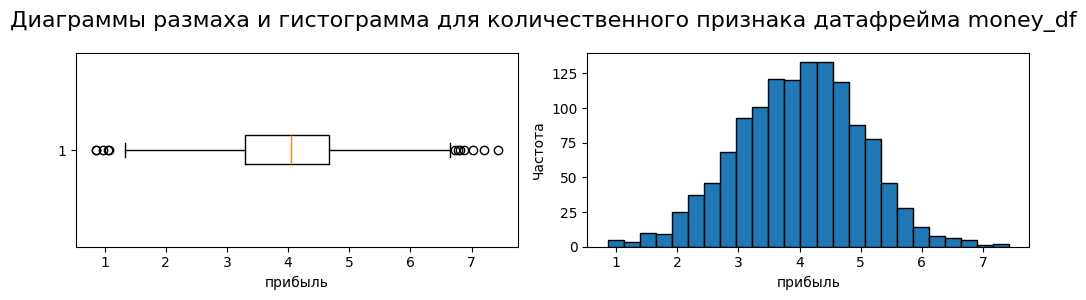

In [51]:
# Создаем фигуру и сетку подграфиков
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

# Строим диаграммы размаха
build_boxplot(money_df, 'прибыль', 'прибыль', axs[0])
build_histogram(money_df, 'прибыль', 'прибыль', 25, axs[1])


# Добавляем общее название для фигуры
fig.suptitle('Диаграммы размаха и гистограмма для количественного признака датафрейма money_df', fontsize=16)

# Настраиваем расстояние между подграфиками
plt.tight_layout(pad=1.0)

# Отображаем графики
plt.show()

Визуализация распределения количественного признака `прибыль` с помощью диаграмм наглядно подтвердила выводы, сделанные на основе числового описания.

### Отбор клиентов с покупательской активностью не менее трех месяцев

На основе имеющихся данных нет информации о покупательской активности клиентов за три месяца, только за два: текущий и предыдущий. Соответственно отбирать клиентов будем исходя из этих данных. Ранее для датафрейма `market_money_df` найдены `id` клиентов, которые имели нулевую выручку в один из периодов. По заданию такие клиенты должны быть исключены.

In [52]:
# удалим из всех датасетов клиентов с нулевой выручкой
market_file_df = (market_file_df
                  .drop(market_file_df[market_file_df['id'].isin(id_0)].index)
                  .reset_index(drop=True)
                 )
market_money_df = (market_money_df
                   .drop(market_money_df[market_money_df['id'].isin(id_0)].index)
                   .reset_index(drop=True)
                  )
market_time_df = (market_time_df
                  .drop(market_time_df[market_time_df['id'].isin(id_0)].index)
                  .reset_index(drop=True)
                 )
money_df = (money_df
            .drop(money_df[money_df['id'].isin(id_0)].index)
            .reset_index(drop=True)
           )

### Выводы по исследовательскому анализу

1. Целевой бинарный признак `покупательская_активность` имеет некоторый дисбаланс (38/62), что нужно будет иметь ввиду при настройке модели машинного обучения.
2. Медианное и среднее значения для большинства числовых признаков достаточно близки друг к другу, что говорит о том, что данные распределены симметрично по "весу" относительно медианного значения. Выделяется сред всех признак `акционные_покупки`, который имеет два пика: максимальный в районе 0.20-0.25 и побочный вблизи 0.9, что увеличивает среднее значение относительно медианного.  
3. Относительное стандартное отклонение, которое характеризует разброс данных и является стандартным отклонением в процентном соотношении от медианного значения, для всех числовых признаков имеет достаточно большое значение, чтобы сделать предположение, о том, что все числовые признаки могут вносить некий вклад в предсказательную способность модели (в случае корреляции с целевым признаком).
4. Категории товаров по популярности распределились следующим образом от наиболее популярного к наименее популярному: товары для детей, домашний текстиль, косметика и аксессуары, техника для красоты и здоровья, мелкая бытовая техника и электроника, кухонная посуда.
5. В числовом признаке `выручка` обнаружено аномально большое значение, отличающееся от основной массы на два порядка. Для того, чтобы исключить его орицательное влияние на модель машинного обучения, клиент с таким значением выручки был удален во всех датаферймах.
6. В датафреймах `market_time_df` и `market_money_df` каждый пользователь с конкретным `id` несколько раз числится: со значениями в категориальном признаке `период` за предыдущий и текущий месяцы. При объединении датафреймов нужно будет учесть данную особенность.

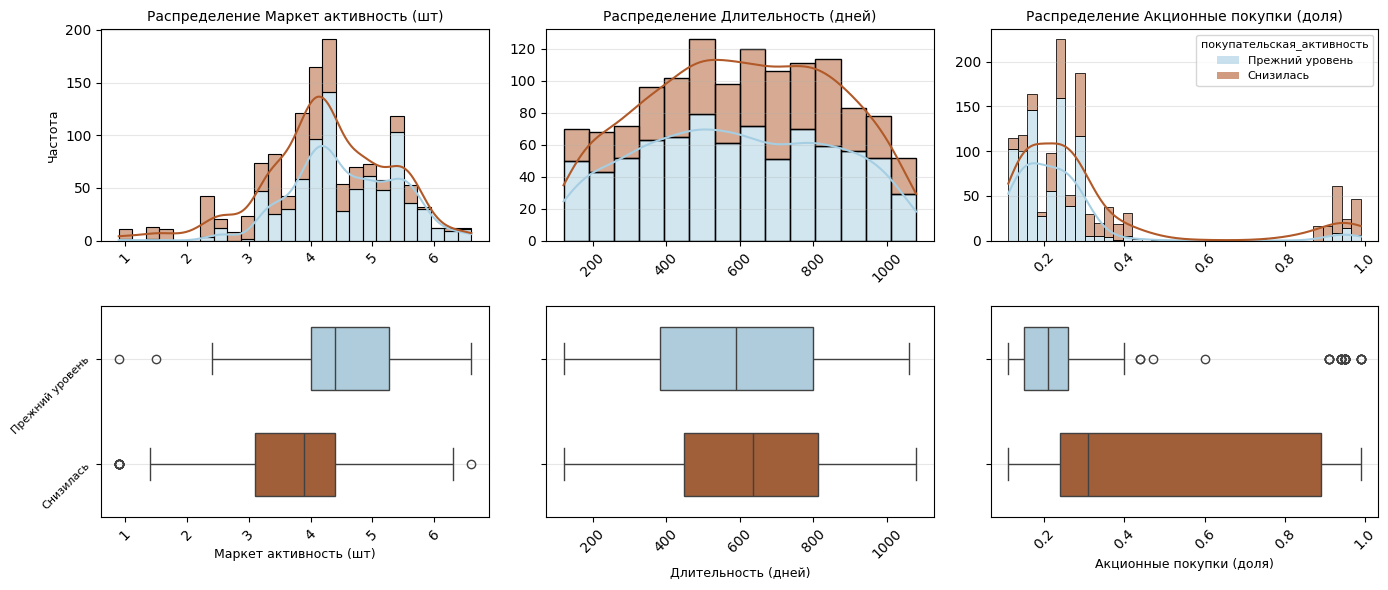

In [53]:
# Применение функции plot_distribution_with_boxplot к количественным непрерывным признакам
features = [
    ('маркет_актив_6_мес', 'Маркет активность (шт)'),
    ('длительность', 'Длительность (дней)'),
    ('акционные_покупки', 'Акционные покупки (доля)'),
]

plot_distribution_with_boxplot(
    market_file_df,
    features,
    'покупательская_активность'
)

In [54]:
# Список категориальных признаков (исключая целевой)
categorical_features = [
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория'
]

# Построение диаграмм, используя plot_categorical_sunburst
plot_categorical_sunburst(
    market_file_df,
    categorical_features,
    'покупательская_активность'
)

## Объединение датафреймов

Объединим датафреймы, которые потребуются для моделирования. Из датафреймов `market_money_df` и `market_time_df` создадим сводные таблицы, в которых разделим данные по каждому клиенту по периодам: предыдущий и текущий. Во всех трех датафреймах в качестве индекса установим столбец `id`. 

In [55]:
# создадим сводную таблицу market_money_df
pivot_market_money_df = pd.pivot_table(
    market_money_df,
    values='выручка',
    index='id',
    columns='период',
    aggfunc='sum',
    fill_value=0
).rename(columns={'предыдущий_месяц' : 'выручка_предыдущий', 'текущий_месяц' : 'выручка_текущий'})

In [56]:
# создадим сводную таблицу market_time_df
pivot_market_time_df = pd.pivot_table(
    market_time_df,
    values='минут',
    index='id',
    columns='период',
    aggfunc='sum',
    fill_value=0
).rename(columns={'предыдущий_месяц' : 'мин_предыдущий', 'текущий_месяц' : 'мин_текущий'})

In [57]:
# устанавим столбец 'id' в качестве индекса датафрейма market_file_df
market_file_df.set_index('id', inplace=True)

Создадим новый датафрейм с помощью объединения трех датафреймов по индексам.

In [58]:
# используем join для объединения трех датафреймов по индексам
market_df = market_file_df.join([pivot_market_money_df, pivot_market_time_df])

In [59]:
# проверяем результат объединения
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

**Вывод —** Объединение датафреймов прошло успешно.

## Корреляционный анализ

Проведем корреляционный анализ признаков в итоговом датафрейме `market_df` для моделирования. Будем рассчитывать Phik-коэффициенты, так как планируется обучать в числе прочего нелинейные модели. Такой метод является универсальным и подходит для любых типов данных: числовых, категориальных или их сочетания. Поэтому будем рассчитывать Phik-коэффициенты для всех признаков датафрейма.

Создаем функцию для построения матрицы корреляции Phik и датафрейма с отсортированными строками по значению коэффициента по убыванию, но превышающему порог, устанавливаемый пользователем. Будем считать, что присутствует мультиколлинеарность, если хотя бы у одной пары признаков коэффициент Phik будет больше или равен 0.9. В качестве порога выберем 0.9, чтобы можно было бы сразу вывести пары признаков с мультиколлинеарностью.

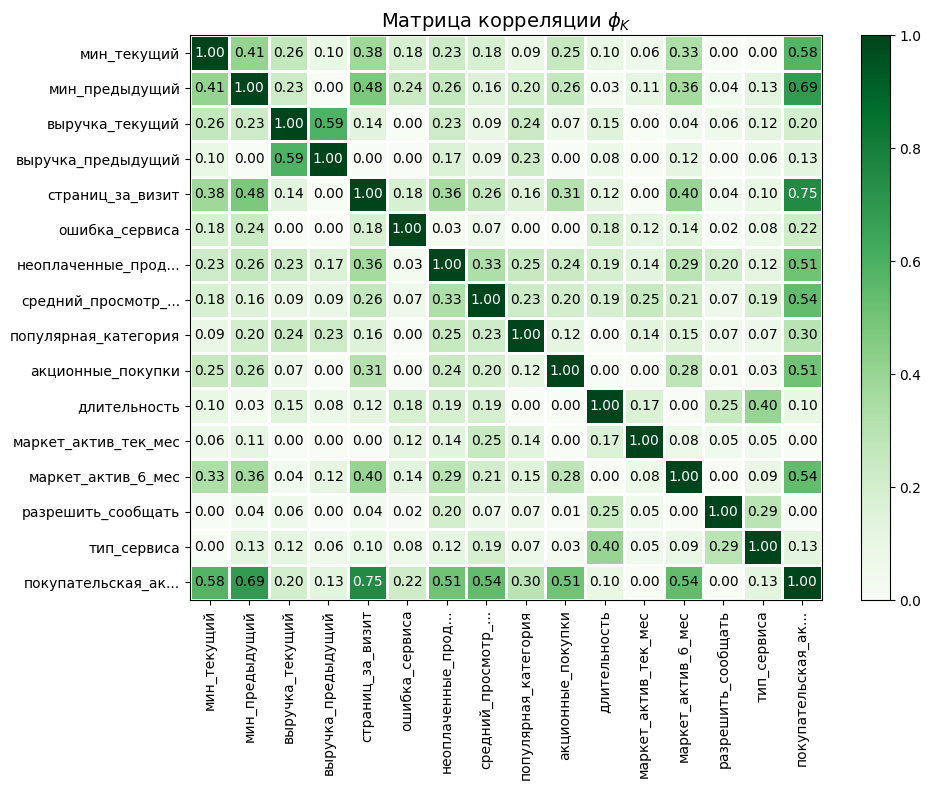

Мультиколлинеарность между парами входных признаков отсутствует


In [60]:
# рассчитаем матрицу корреляции Phik
# присвоем переменной phik_sorted датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
phik_sorted, interval_cols = phik_correlation_matrix(market_df, threshold = 0.9, output_interval_cols=True)

По результатам расчета Phik-коэффициентов мы делаем вывод, что мультиколлинеарность отсутствует. Однако есть входные признаки, которые не имеют корреляции непосредственно с целевым признаком `покупательская_активность`. К таким входным признакам относятся: `маркет_актив_тек_мес`, `разрешить_сообщать`. Однако в совокупности с другими входными признаками, они могут улучшить предсказательную способность модели и ее метрики в целом. Поэтому при первом моделировании будем использовать все признаки.

Рассчитаем теперь Phik-коэффициенты для датафрейма только с клиентами, которые с прежней покупательской активностью. 

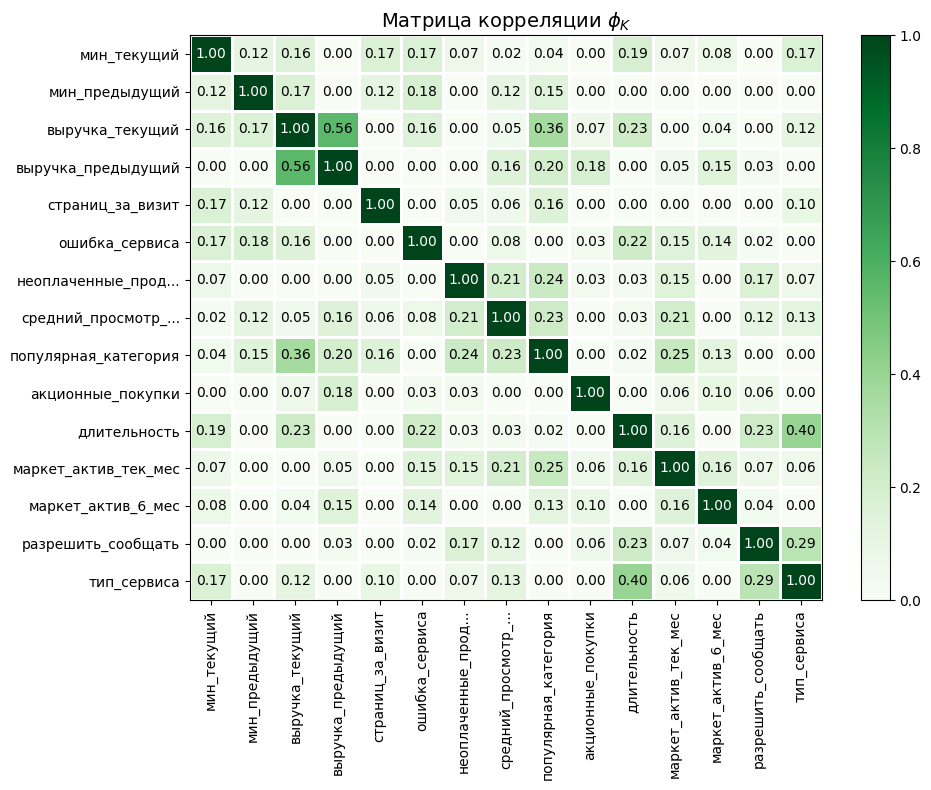

Мультиколлинеарность между парами входных признаков отсутствует


In [61]:
# сделаем срез покупательская_активность=="Прежний уровень"
market_df_1 = market_df.query('покупательская_активность=="Прежний уровень"')
# рассчитаем матрицу корреляции Phik для клиентов со снижением покупательской активности
# присвоем переменной phik_sorted датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
phik_sorted, interval_cols = phik_correlation_matrix(market_df_1.drop(columns=['покупательская_активность']), threshold = 0.9, output_interval_cols=True)

Рассчитаем теперь Phik-коэффициенты для датафрейма только с клиентами, которые со сниженной покупательской активностью. 

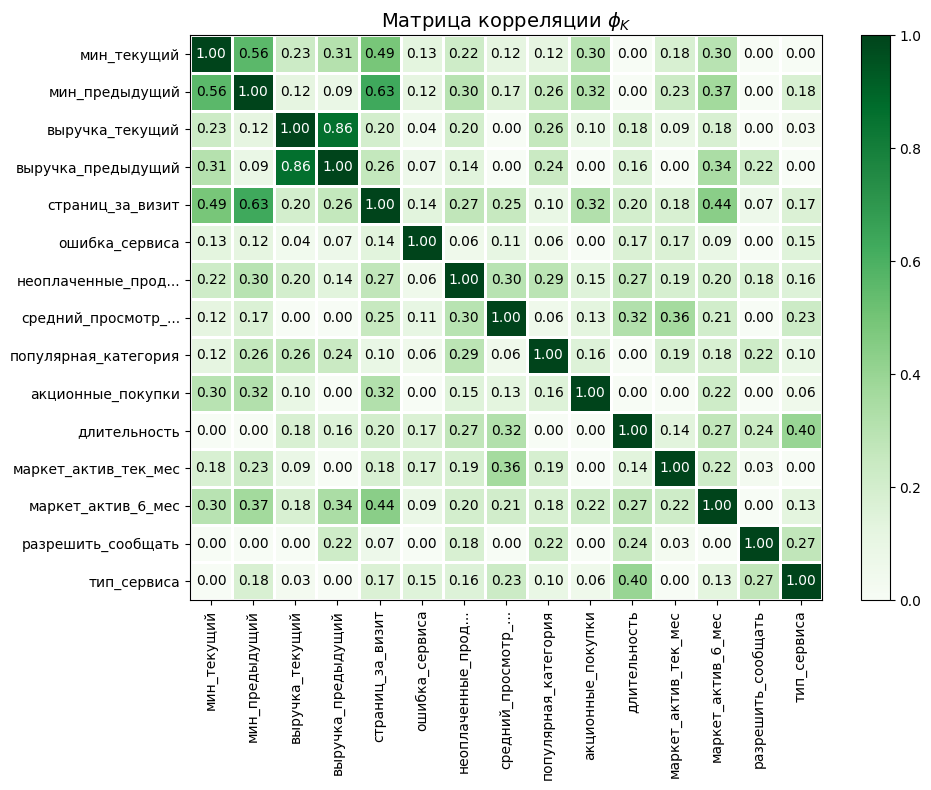

Мультиколлинеарность между парами входных признаков отсутствует


In [62]:
# сделаем срез покупательская_активность=="Снизилась"
market_df_2 = market_df.query('покупательская_активность=="Снизилась"')
# рассчитаем матрицу корреляции Phik для клиентов со снижением покупательской активности
# присвоем переменной phik_sorted датафрейм с парами признаков и их корреляцией Фи
# присвоем переменной threshold пороговое значение
# присвоем переменной interval_cols список названий всех столбцов с числовым типом данных в обрабатываемом датафрейме
phik_sorted, interval_cols = phik_correlation_matrix(market_df_2.drop(columns=['покупательская_активность']), threshold = 0.9, output_interval_cols=True)

Мультиколлинеарность по-прежнему отсутствует между парами входных признаков. Однако в случае только клиентов со сниженной активностью наблюдается усиление связей `страниц_за_визит`-`мин_текущий` и `мин_предыдущий`, `выручка_предыдущий`-`мин_текущий`, `страница_за_визит`-`маркет_актив_6_мес` и в целом для признаков `страниц_за_визит` и `маркет_актив_6_мес` со всеми остальными признаками корреляция усилилась, а где-то в принципе появилась. Эти различия в коэффицинтах Фи-К указывают на разное покупательское поведение клиентов с разной активностью, которое можно попытаться предсказать.

#### Коэффициент инфляции дисперсии: исследование мультиколлинеарности

Коэффициент инфляции дисперсии (variance inflation factor — VIF) измеряет насколько сильно дисперсия коэффициента регрессии увеличивается из-за мультиколлинеарности. Различают следующие категории мультиколлинеарности по значению VIF:
- вблизи 1 — отсутствует или пренебрежимо слабая;
- больше 5–10 — умеренная или сильная (требует внимания);
- больше 100 — критическая (модель ненадежна).

Используем созданную фукнцию `vif_` для расчета коэффициентов инфляции диспресии и рассчитаем их для всех входных признаков датафрейма `market_df`.

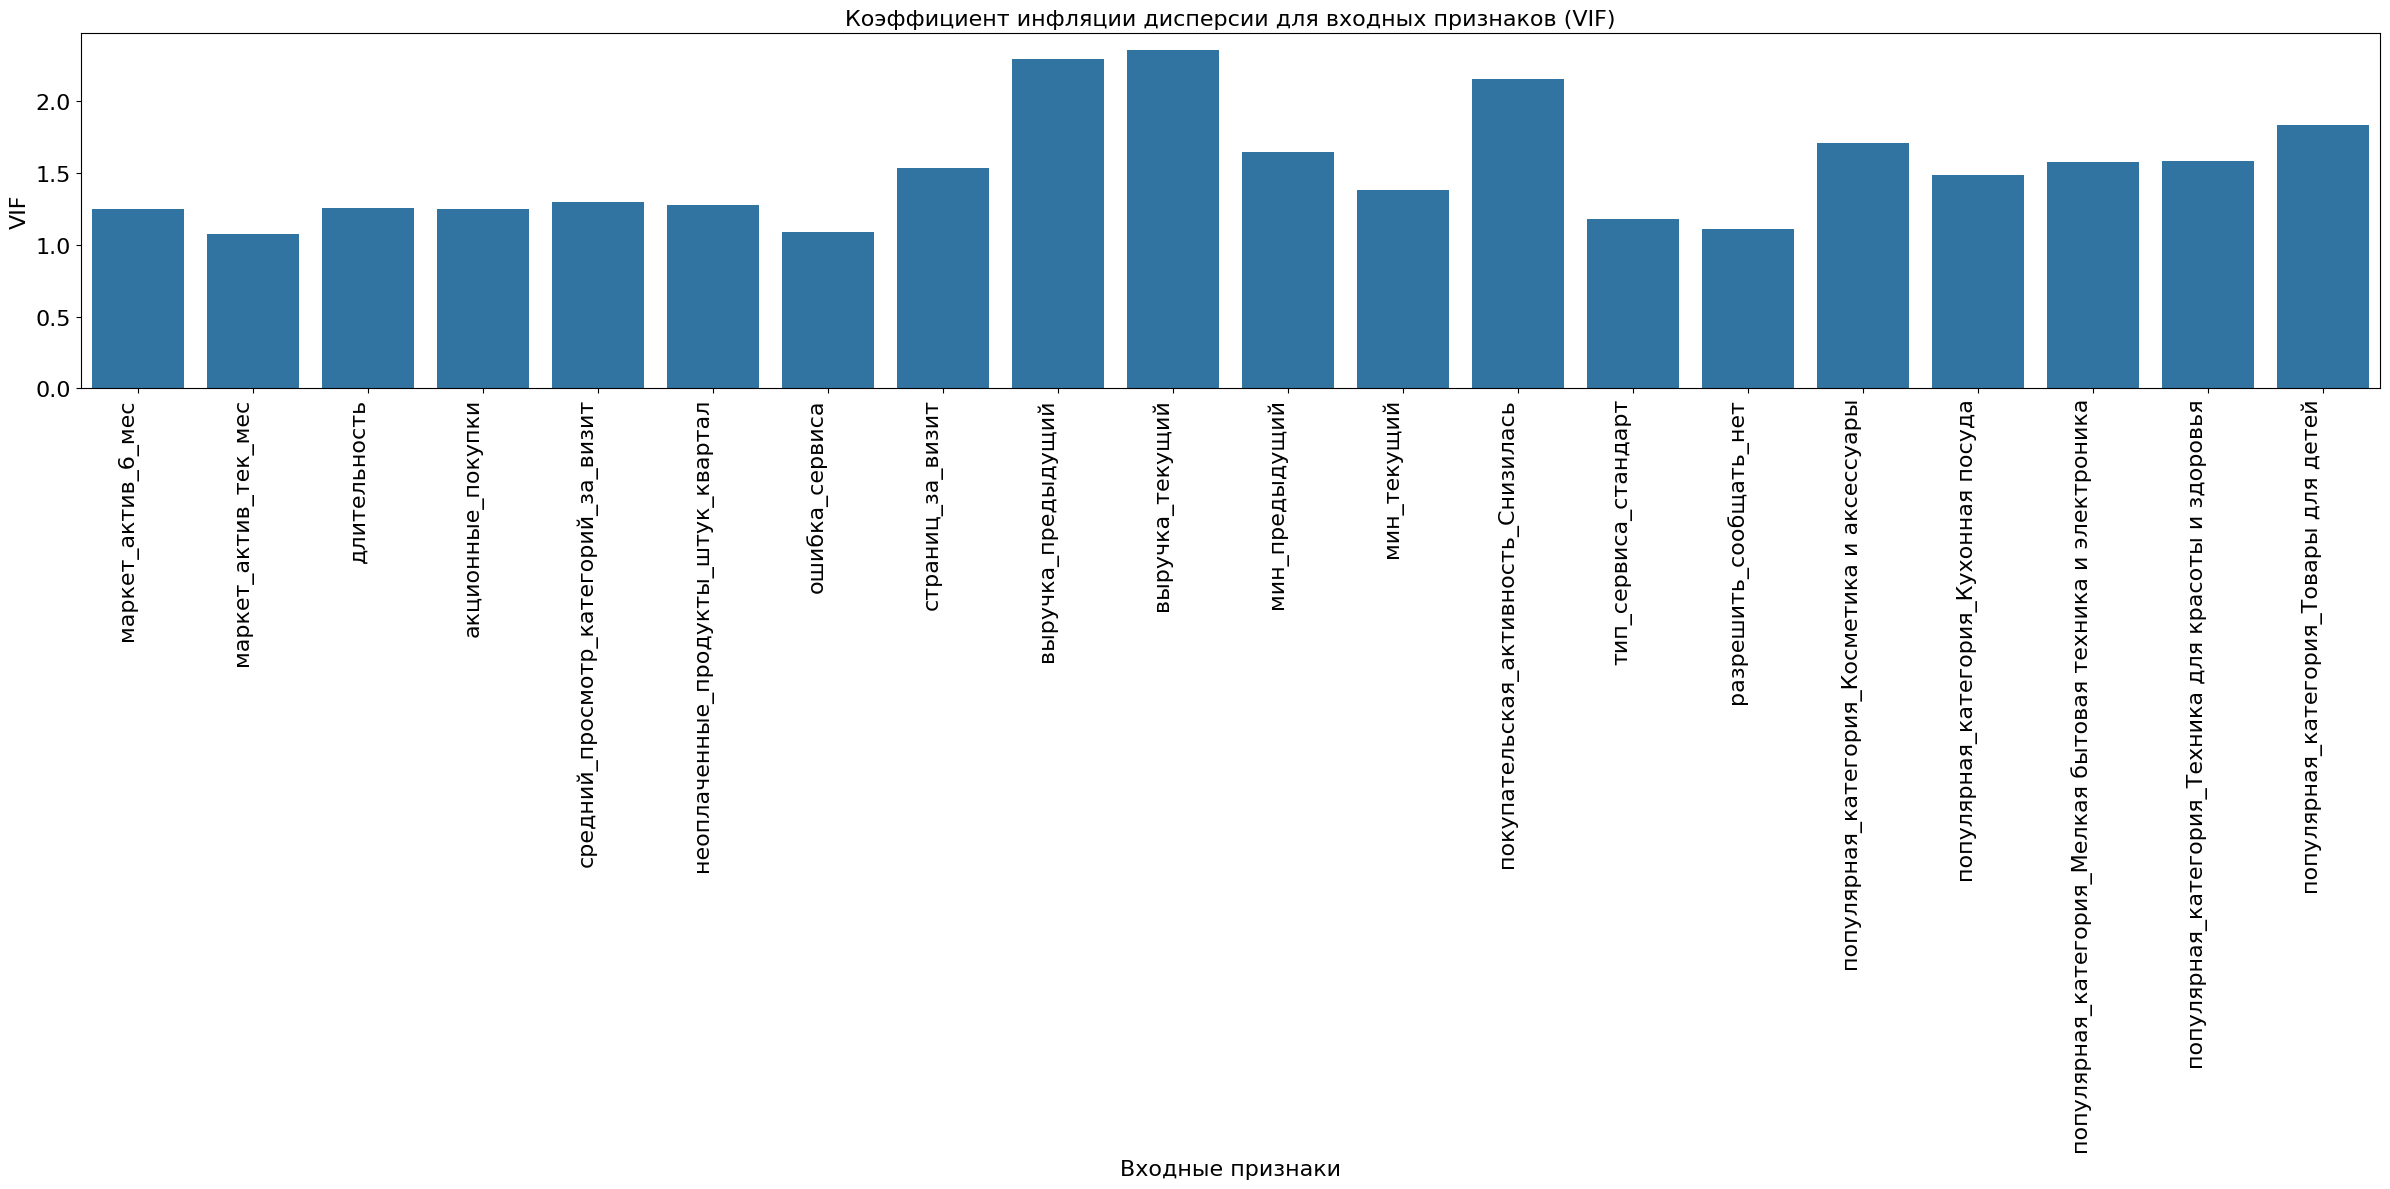

In [63]:
# используем созданную функцию рассчета VIF 
vif_(market_df, font_size=16)

**Вывод по расчету коэффициента инфляции дисперсии.**

Мы наблюдаем, что для признаков нет мультиколлинеарности или она слабая.

## Использование пайплайнов

Выберем метрику ROC-AUC, так как она слабо чувствительна к дисбалансу классов, который наблюдается у целевого признака. Данная метрика также выбрана по следующим причинам:
- объективно сравнивает разные модели, так как она измеряет общую способность модели ранжировать примеры;
- независимость от порога классификации.

In [64]:
# делим данные на тренировачные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(
    market_df.drop(['покупательская_активность'], axis=1),
    market_df['покупательская_активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = market_df['покупательская_активность'])

In [65]:
# создаем списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
ord_columns = ['тип_сервиса']
num_columns = interval_cols

# создаем пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаем пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[['стандарт', 'премиум']], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
    ], 
    remainder='passthrough'
)

# создаем итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [66]:
# задаем сетку гиперпараметров моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [67]:
%%time
# поиск лучшей модели
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и ее параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели по кросс-валидационной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Лучшая модель и ее параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                 

In [68]:
# установим неограниченное количество символов для отображения в строке
pd.set_option('display.max_colwidth', None)

# выведем результат кросс-валидации
result = pd.DataFrame(randomized_search.cv_results_)
print(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score').head())

   rank_test_score  \
5                1   
2                2   
3                3   
7                4   
9                5   

                                                            param_models  \
5                                                  SVC(probability=True)   
2  LogisticRegression(penalty='l1', random_state=42, solver='liblinear')   
3  LogisticRegression(penalty='l1', random_state=42, solver='liblinear')   
7                                                  SVC(probability=True)   
9                                                  SVC(probability=True)   

   mean_test_score  \
5         0.906216   
2         0.896975   
3         0.896635   
7         0.891344   
9         0.887225   

                                                                                                                                     params  
5                                         {'preprocessor__num': StandardScaler(), 'models__kernel': 'rbf', 'models': SVC(probability=Tr

Итак, лучшей моделью по метрике ROC-AUC оказалась модель `SVC` с ядром `rbf`, а лучшим скейлером — `StandardScaler`. Равенство ROC-AUC для предсказаний на тестовой и тренировочной выборках указывает на то, что модель хорошо обучилась и обнаружила важные закономерности в данных. При этом значение ROC-AUC 0.906 достаточно большое, что характеризует ее высокое качество и хорошие предсказательные способности.

## Анализ важности признаков

In [69]:
# Получаем лучшую модель из RandomizedSearchCV
best_model = randomized_search.best_estimator_
print("Лучшая модель получена.")

# Извлекаем только модель SVC из пайплайна
svc_model = best_model.named_steps['models']
print("Модель SVC извлечена.")

# Извлекаем только preprocessor из пайплайна
preprocessor = best_model.named_steps['preprocessor']

# Применяем преобразования данных из пайплайна к X_train и X_test
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
print("Данные трансформированы.")

# Сокращаем размер обучающих данных для SHAP
background_data = shap.sample(X_train_transformed, 100)
print("Background data подготовлен.")

# Создаем объект explainer для SHAP
explainer = shap.KernelExplainer(svc_model.predict_proba, background_data)
print("Explainer создан.")

Лучшая модель получена.
Модель SVC извлечена.
Данные трансформированы.
Background data подготовлен.
Explainer создан.


In [70]:
%%time
# Вычисляем SHAP-значения для тестовой выборки
shap_values = explainer.shap_values(X_test_transformed[:5])  # Используем подвыборку
print("SHAP-значения вычислены.")

  0%|          | 0/5 [00:00<?, ?it/s]

SHAP-значения вычислены.
CPU times: total: 1min 2s
Wall time: 59.8 s


In [71]:
# Смотрим порядок классов
print("Порядок классов в модели:", best_model.classes_)

Порядок классов в модели: ['Прежний уровень' 'Снизилась']


Размерность shap_values_trimmed: (5, 19)
Размерность X_test_transformed: (5, 19)


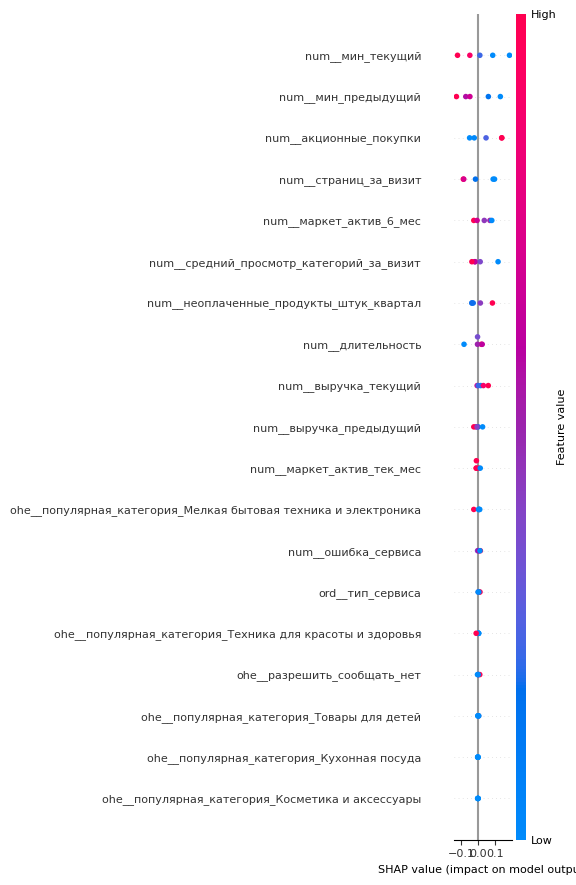

In [72]:
# Выбираем SHAP-значения для класса 1, так как столбцу с индексом 1 сответствует вероятность того,
# что покупательская активность снизилась
shap_values_positive_class = shap_values[:, :, 1]  

# Проверяем размерности
print("Размерность shap_values_trimmed:", shap_values_positive_class.shape)
print("Размерность X_test_transformed:", X_test_transformed[:5].shape)

assert shap_values_positive_class.shape[1] == X_test_transformed[:5].shape[1], "Количество признаков в shap_values_positive_class и X_test_transformed не совпадает"

# Получаем корректные имена признаков после преобразований
feature_names = market_df.drop(['покупательская_активность'], axis=1).columns
transformed_feature_names = preprocessor.get_feature_names_out(input_features=feature_names)

# Построение графика важности признаков
shap.summary_plot(shap_values_positive_class, X_test_transformed[:5], feature_names=transformed_feature_names, show=False)

# Настройка размера шрифта
for ax in plt.gcf().axes:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)  # Устанавливаем размер шрифта

# Показываем график
plt.show()

**Анализ графика**

График представляет собой SHAP (SHapley Additive exPlanations) beeswarm plot, который показывает влияние различных признаков на предсказание модели. По оси X отображается значение SHAP, которое указывает на степень влияния каждого признака на выход модели. Положительные значения SHAP смещают предсказание в сторону покупательская активность снизилась (положительная связь с таргетом), а отрицательные — осталась на прежнем уровне (отрицательная связь с таргетом).

*Положительная связь с таргетом:*

num_акционные_покупки, num_неоплаченные_продукты_штук_квартал, num_выручка_текущий.


*Отрицательная связь с таргетом:*

num_мин_текущий, num_мин_предыдущий, num_маркт_актив_6_мес, num_маркт_актив_тек_мес,
num_страниц_за_визит.

*Слабая или нейтральная связь:*
num_ошибка_сервиса, ohe_популярная_категория_Мелкая бытовая техника и электроника, ohe_популярная_категория_Косметика и аксессуары, ord__тип_сервиса и другие признаки, расположенные ближе к нулю по оси X, имеют слабое или нейтральное влияние на таргет.


*Выводы для сегментирования и понимания данных:*

*Сегментация клиентов:*

Клиенты с высокими значениями num_мин_текущий, num_акционные_покупки и num_неоплаченные_продукты_штук_квартал могут быть сегментированы как активные пользователи, которые вносят значительный вклад в таргет.
Клиенты с высоким количеством num_неоплаченные_продукты_штук_квартал и частыми num_ошибка_сервиса могут быть сегментированы как проблемные клиенты, требующие дополнительного внимания и улучшения сервиса.

*Понимание поведения клиентов:*

Активность клиентов в текущем периоде (num_мин_текущий, num_акционные_покупки) имеет большее влияние на таргет, чем их активность в предыдущем периоде (num_мин_предыдущий).
Категории товаров, такие как "Мелкая бытовая техника и электроника", положительно влияют на таргет, в то время как "Косметика и аксессуары" имеют слабое влияние. Это может указывать на то, что клиенты более склонны покупать технику и электронику, чем косметику.

*Заключение*

Несмотря на ограниченное количество примеров, анализ SHAP beeswarm plot позволяет сделать некоторые важные выводы о взаимосвязях между признаками и таргетом. Эти выводы могут быть использованы для улучшения сегментации клиентов и понимания их поведения, что в свою очередь поможет оптимизировать стратегии продаж и маркетинга.

**1. Какие признаки мало значимы для модели?**

Некоторые признаки имеют очень маленькие значения SHAP, близкие к нулю. Это означает, что они почти не влияют на итоговый результат модели. Например, признак `ohe_популярная_категория_Косметика и аксессуары` показывает очень низкую значимость, с SHAP-значениями близкими к нулю. То же самое касается `ohe_популярная_категория_Кухонная посуда` и `ohe_популярная_категория_Товары для детей`. Эти признаки, видимо, не играют значительной роли в определении целевого признака. Еще один признак, `ohe_разрешить_сообщать_нет`, также кажется мало значимым, судя по низким SHAP-значениям.

**2. Какие признаки сильнее всего влияют на целевой признак?**

Здесь нужно смотреть на те признаки, которые имеют самые высокие по модулю SHAP-значения. Это значит, что они сильно влияют на результат модели, либо уводя его в сторону снизилась покупательская активность или в сторону осталась прежней. Например, `num_мин_текущий` и `num_мин_предыдущий` показывают значительное влияние, но с SHAP-значениями, которые могут быть как положительными, так и отрицательными, в зависимости от значения признака: низкие значения смещают предсказание в сторону покупательская активность снизилась, а высокие значения наоборот — осталась прежняя. Другой признак, `num_акционные_покупки`, также кажется важным, поскольку его SHAP-значения распространяются на значительный диапазон, указывая на сильное влияние на модель. Причем влияние значения данного признака на предсказание противоположное относительно двух предыдущих признаков. Стоит также отметить, что высокие значения данного признака сильнее влияют на результат модели нежели низкие. Также стоит отметить `num_страниц_за_визит`, который имеет значения, преимущественно низкие, которые смещают результат предсказания в сторону снижения покупательской активности. Еще один значимый признак — `num_маркет_актив_6_мес`, который также показывает сильное влияние на модель.

**3. Как можно использовать эти наблюдения при моделировании и принятии бизнес-решений?**

Прежде всего, понимание важности признаков помогает оптимизировать модель. Например, если некоторые признаки имеют низкую значимость, их можно исключить из модели, чтобы упростить ее и сократить время обучения без значительной потери точности.

Кроме того, знание ключевых признаков позволяет сосредоточиться на сборе и улучшении качества этих данных, поскольку они оказывают наибольшее влияние на результаты модели.

С бизнес-перспективы, понимание, какие факторы влияют на целевой признак, может дать ценные инсайты. Например, если `num_мин_текущий`, `num_мин_предыдущий` являются ключевыми факторами, возможно, стоит уделить больше внимания увеличению значения времени, проведенного на сайте. Что согласуется с увеличением вероятности остаться клиента на прежнем уровне покупательской активности с ростом среднего количества страниц, которые просмотрел покупатель за один визит на сайт (признак `num_страниц_за_визит`).

Также, так как `num_акционные_покупки` сильно влияет на модель, причем с определенной доли акционных покупок начинает увеличиваться вероятность снижения покупательской активности клиента, то можно сделать вывод, что акции эффективны до какой-то степени и стоит продолжать их проводить умеренно.

В свою очередь маркетинговая коммуникация с клиентом (признак `num_маркет_актив_6_мес`) сильно влияет на модель положительным образом, следовательно, маркетинг эффективен и стоит продолжать его проводить или даже увеличить его масштаб.

В целом, анализ важности признаков с помощью SHAP помогает не только улучшить модель, но и получить глубокое понимание данных и бизнес-процессов, на основе которых эти данные были сгенерированы.


**Выводы по значениям SHAP:**

1. **Малозначимые признаки:** `ohe_популярная_категория_Косметика и аксессуары`, `ohe_популярная_категория_Кухонная посуда`, `ohe_популярная_категория_Товары для детей` и `ohe_разрешить_сообщать_нет` имеют низкую значимость и могут быть исключены из модели для упрощения.

2. **Ключевые признаки:** `num_мин_текущий`, `num_мин_предыдущий`, `num_акционные_покупки`, `num_страниц_за_визит` и `num_рынок_актив_6_мес` оказывают сильное влияние на модель и должны быть тщательно анализированы и обеспечены высоким качеством данных.

3. **Бизнес-инсайты:** Уделять особое внимание значению времени проведенному на сайте, количеству просмотренных за визит страниц, акционным покупкам и маркетинговой коммуникации, так как они существенно влияют на целевой признак, что может указывать на эффективность маркетинговой стратегии и управления клиентской лояльностью.


**Дополнительные соображения:**

- **Интерпретация SHAP-значений:** SHAP-значения показывают вклад каждого признака в прогноз модели. Положительные значения указывают на то, что покупательская активность снизилась, а отрицательные наоборот — осталась прежней.

- **Проверка признаков:** Перед принятием решений о исключении признаков следует проверить, нет ли среди них тех, которые имеют низкую значимость, но могут быть важны для конкретных сегментов данных или в сочетании с другими признаками.

- **Дальнейший анализ:** Рекомендуется провести более глубокий анализ взаимодействия признаков и их влияния на модель с применением сегментации покупателей.

## Сегментация покупателей

In [73]:
# Создаем датафрейм X, представляющий собой входные признаки для всех клиентов
X = market_df.drop(['покупательская_активность'], axis=1)

# Рассчитываем вероятность прежнего уровня покупательской активности клиентов
y = best_model.predict_proba(X)[:, 1]

# Создаем столбец с вероятностью снижения покупательской активности клиентов в датафрейме market_df
market_df['вероятность_снижения'] = y

In [74]:
# делаем в качестве индекса датафрейма money_df клиентский id
money_df.set_index('id', inplace=True)

# используем join для объединения market_df с датафреймом money_df, в котором есть данные о прибыли продавца от продаж каждому клиенту
market_df = market_df.join(money_df)

In [75]:
# проверяем результат добавления вероятностей и объединения датафреймов
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   object 
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

Добавление вероятности прежнего уровня покупательской активности клиентов и прибыли продавца от продаж клиентам прошло успешно.

Исследуем несколько сегментов покупателей.

### Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.

#### **Сегментация**

За критерий высокой вероятности снижения покупательской активности возьмем значение 0.75, а наиболее высокой прибыльности — значение, соответствующее квантилю 75% — 4.67.

In [76]:
# отфильтруем сегмент покупателей
market_df_1 = market_df.query('вероятность_снижения>0.75 & прибыль>4.67')

In [77]:
# проверим сегментацию
market_df_1[['вероятность_снижения', 'прибыль']].apply(['min', 'count'])

вероятность_снижения  прибыль
min                0.755507     4.68
count             87.000000    87.00

Группа выделена успешно, ее размер — 88 клиентов.

#### **Анализ категориальных признаков**

Задача: Выявить доминирующие категории (тип сервиса, популярная категория, разрешение на сообщения).

In [78]:
# Распределение типов сервиса
print("\033[1mТип сервиса:\033[0m")
print(market_df_1['тип_сервиса'].value_counts(normalize=True))

# Распределение популярных категорий
print("\n\033[1mПопулярные категории:\033[0m")
print(market_df_1['популярная_категория'].value_counts(normalize=True))

# Разрешение на сообщения
print("\n\033[1mРазрешение на сообщения:\033[0m")
print(market_df_1['разрешить_сообщать'].value_counts(normalize=True))

Тип сервиса:
тип_сервиса
стандарт    0.632184
премиум     0.367816
Name: proportion, dtype: float64

Популярные категории:
популярная_категория
Товары для детей                        0.298851
Косметика и аксессуары                  0.264368
Домашний текстиль                       0.183908
Кухонная посуда                         0.103448
Техника для красоты и здоровья          0.091954
Мелкая бытовая техника и электроника    0.057471
Name: proportion, dtype: float64

Разрешение на сообщения:
разрешить_сообщать
да     0.712644
нет    0.287356
Name: proportion, dtype: float64


**Анализ результатов и рекомендации**

**1. Тип сервиса:**

- 63.6% клиентов используют стандартный сервис, 36.4% — премиум.
   
*Вывод:* Даже премиум-клиенты попадают в группу риска. Возможно, их потребности не полностью удовлетворяются.

*Рекомендация:* Провести опрос премиум-клиентов для выявления их боли (например, недостаток эксклюзивных предложений).

**2. Популярные категории:**

- Топ-3: "Товары для детей" (30.7%), "Косметика и аксессуары" (26.1%), "Домашний текстиль" (18.2%).

*Вывод:* Снижение активности может быть связано с сезонностью (например, спад спроса на детские товары вне учебного сезона) или проблемами в этих категориях (ассортимент, цены).

*Рекомендация:*
- Проверить наличие акций в этих категориях.
- Улучшить рекомендации товаров на основе истории покупок.

**3. Разрешение на сообщения:**

71.6% клиентов согласны получать предложения.

*Вывод:* Высокий потенциал для персональных рассылок.

*Рекомендация:* Использовать email/SMS-кампании с персональными скидками на популярные категории.

#### **Сравнение числовых признаков с остальными клиентами вне сегмента**

Задача: Сравнить средние значения ключевых признаков в целевой группе и вне ее.

In [79]:
# Сравнение средних значений
comparison_cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'страниц_за_визит', 'мин_текущий', 'мин_предыдущий'
]

print("\033[1mСредние значения в группе:\033[0m")
print(market_df_1[comparison_cols].mean())

print("\n\033[1mСредние значения вне группы:\033[0m")
print(market_df[~market_df.index.isin(market_df_1.index)][comparison_cols].mean())

Средние значения в группе:
маркет_актив_6_мес                    3.496552
маркет_актив_тек_мес                  4.091954
неоплаченные_продукты_штук_квартал    4.103448
ошибка_сервиса                        3.712644
страниц_за_визит                      4.172414
мин_текущий                           9.816092
мин_предыдущий                        9.689655
dtype: float64

Средние значения вне группы:
маркет_актив_6_мес                     4.311084
маркет_актив_тек_мес                   4.003309
неоплаченные_продукты_штук_квартал     2.751034
ошибка_сервиса                         4.218362
страниц_за_визит                       8.476427
мин_текущий                           13.454921
мин_предыдущий                        13.742763
dtype: float64


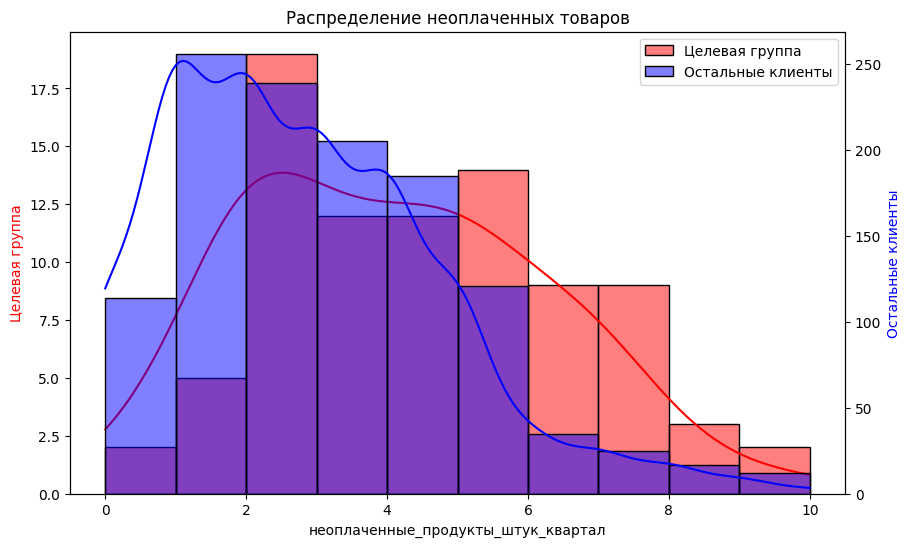

In [80]:
# Визуализация распределения неоплаченных товаров
# Гистограммы

# Создание фигуры и первой оси
fig, ax1 = plt.subplots(figsize=(10, 6))

# Построение первой гистограммы на первой оси
sns.histplot(
    market_df_1['неоплаченные_продукты_штук_квартал'],
    kde=True,
    bins=10,
    color='red',
    label='Целевая группа',
    ax=ax1
)
ax1.set_ylabel('Целевая группа', color='red')

# Создание второй оси
ax2 = ax1.twinx()

# Построение второй гистограммы на второй оси
sns.histplot(
    market_df[~market_df.index.isin(market_df_1.index)]['неоплаченные_продукты_штук_квартал'],
    kde=True,
    bins=10,
    color='blue',
    label='Остальные клиенты',
    ax=ax2
)
ax2.set_ylabel('Остальные клиенты', color='blue')

# Настройка легенды
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.title('Распределение неоплаченных товаров')
plt.show()

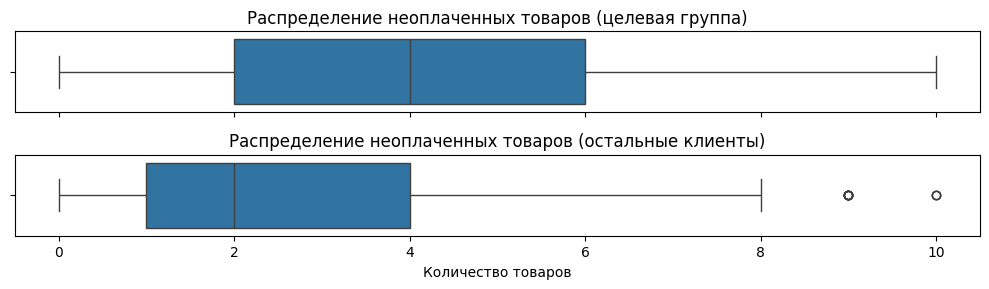

In [81]:
# Визуализация распределения неоплаченных товаров
# Диаграммы размаха

# Создаем фигуру с двумя подграфиками, расположенными вертикально
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# Первая диаграмма размаха
sns.boxplot(
    x=market_df_1['неоплаченные_продукты_штук_квартал'],
    orient='h',
    ax=axes[0]
)
axes[0].set_title('Распределение неоплаченных товаров (целевая группа)')
axes[0].set_xlabel('Количество товаров')

# Вторая диаграмма размаха
sns.boxplot(
    x=market_df[~market_df.index.isin(market_df_1.index)]['неоплаченные_продукты_штук_квартал'],
    orient='h',
    ax=axes[1]
)
axes[1].set_title('Распределение неоплаченных товаров (остальные клиенты)')
axes[1].set_xlabel('Количество товаров')

# Убираем пустое пространство между графиками
plt.tight_layout()
plt.show()

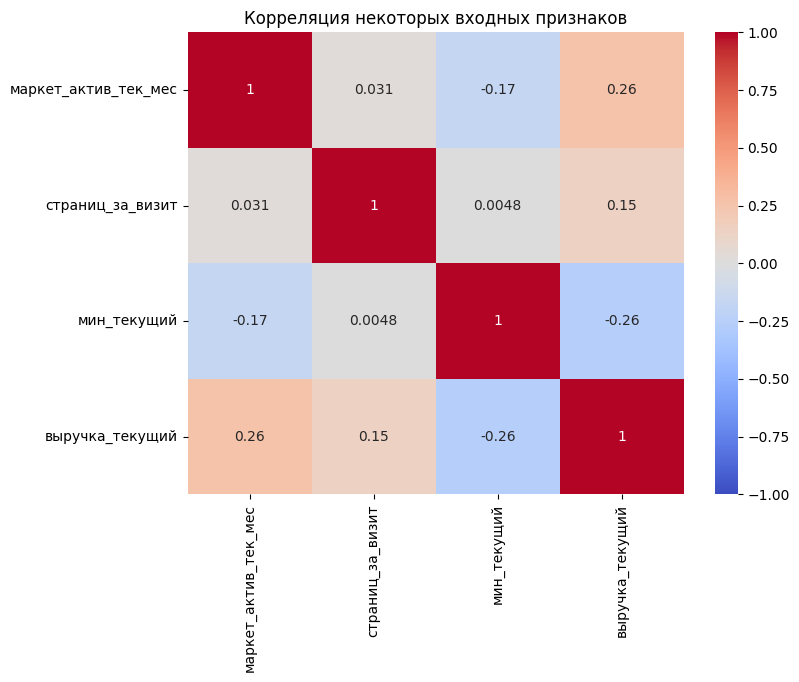

In [82]:
# матрица корреляции некоторых входных признаков

corr_matrix = market_df_1[[
    'маркет_актив_тек_мес', 
    'страниц_за_визит', 
    'мин_текущий', 
    'выручка_текущий'
]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция некоторых входных признаков')
plt.show()

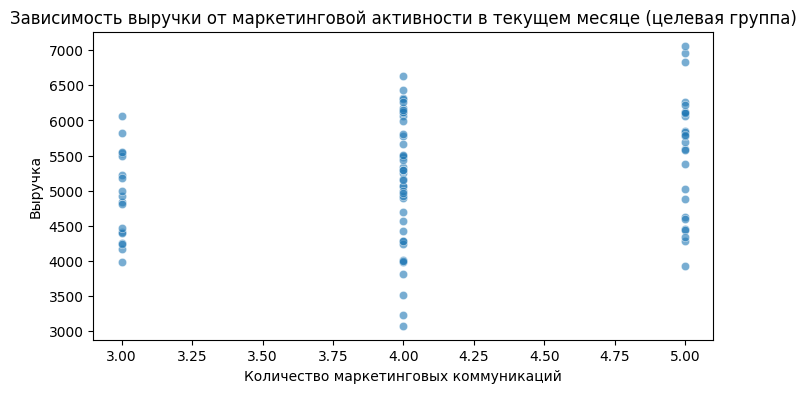

In [83]:
# Диаграмма рассеяния выручка - маркетинговая активность

# Создаем диаграмму рассеяния
plt.figure(figsize=(8, 4))
sns.scatterplot(
    x=market_df_1['маркет_актив_тек_мес'],
    y=market_df_1['выручка_текущий'],
    alpha=0.6
)
plt.title('Зависимость выручки от маркетинговой активности в текущем месяце (целевая группа)')
plt.xlabel('Количество маркетинговых коммуникаций')
plt.ylabel('Выручка')
plt.show()


**Анализ результатов и рекомендации**

**1. Маркетинговая активность:**
- В группе за 6 месяцев: маркет_актив_6_мес = 3.49 (ниже, чем вне группы: 4.31).
- В группе в текущем месяце: маркет_актив_тек_мес = 4.10 (выше, чем вне группы: 4.00).
- Между маркетинговой активностью и выручкой есть небольшая прямая корреляция в текущем месяце.

*Вывод:*
- Резкое увеличение рассылок в текущем месяце могло спровоцировать снижение покупательской активности (перегруз клиента).

*Рекомендация:* Снизить частоту рассылок, но повысить их релевантность (например, упоминать брошенные товары).

**2. Неоплаченные товары:**
- В группе: 4.06 товаров за квартал (против 2.75 вне группы).

*Вывод:* Клиенты часто добавляют товары в корзину, но не завершают покупку.

*Рекомендация:*
- Отправлять напоминания о брошенной корзине (71.6% согласны на рассылки).
- Ввести акции (например, скидка 10% при оплате в течение часа).

**3. Ошибки сервиса:**
- В группе: 3.74 ошибки (против 4.22 вне группы).

*Вывод:* Технические проблемы не являются ключевой причиной снижения активности.

*Рекомендация:* Продолжить мониторинг, но не фокусироваться на этом.

**4. Поведение на сайте:**
- страниц_за_визит: 4.17 (против 8.48 вне группы).
- Время на сайте: 9.7–9.9 минут (13.5-13.7 минут).

*Вывод:* Клиенты группы мало взаимодействуют с сайтом.

*Рекомендация:*
- Упростить навигацию (например, добавить быстрые ссылки на популярные категории).
- Внедрить чат-бота для помощи в выборе.

#### **Анализ динамики выручки и времени на сайте**

Задача: Проверить, как изменились выручка и время на сайте.

In [84]:
# Динамика выручки
print("\033[1mДинамика выручки (текущий vs предыдущий):\033[0m")
print(market_df_1[['выручка_предыдущий', 'выручка_текущий']].mean())

# Динамика времени на сайте
print("\n\033[1mДинамика времени на сайте (мин):\033[0m")
print(market_df_1[['мин_предыдущий', 'мин_текущий']].mean())

Динамика выручки (текущий vs предыдущий):
выручка_предыдущий    9435.988506
выручка_текущий       5212.521839
dtype: float64

Динамика времени на сайте (мин):
мин_предыдущий    9.689655
мин_текущий       9.816092
dtype: float64


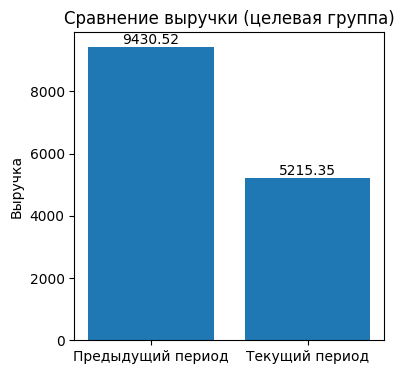

In [85]:
# Создание столбчатой диаграммы
plt.figure(figsize=(4, 4))
bars = plt.bar(['Предыдущий период', 'Текущий период'], [9430.52, 5215.35])
plt.title('Сравнение выручки (целевая группа)')
plt.ylabel('Выручка')

# Добавление подписей значений на столбцах
for bar, value in zip(bars, [9430.52, 5215.35]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2), ha='center', va='bottom')

plt.show()

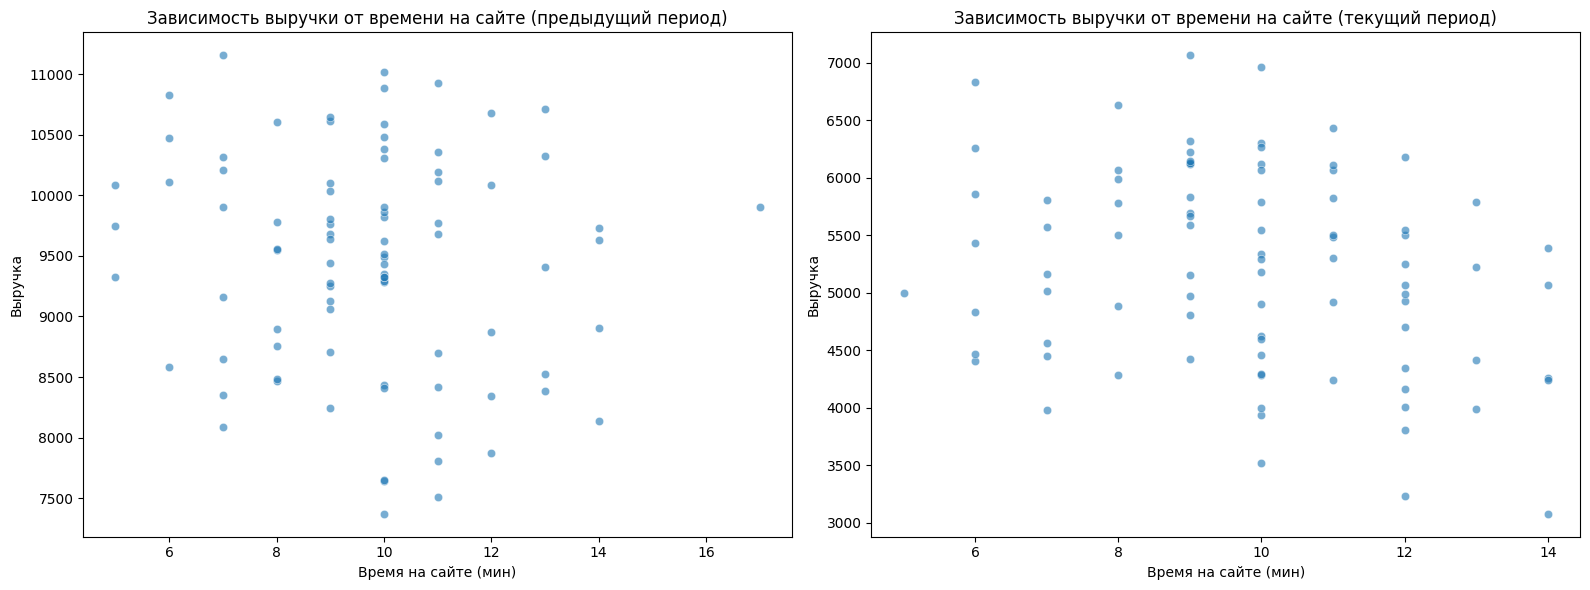

In [86]:
# визуализация корреляции между временем на сайте и выручкой
# диаграммы рассеяния выручка-время для двух периодов

# Создаем фигуру с двумя подграфиками в одной строке
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Первый график
sns.scatterplot(
    x=market_df_1['мин_предыдущий'],
    y=market_df_1['выручка_предыдущий'],
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title('Зависимость выручки от времени на сайте (предыдущий период)')
axes[0].set_xlabel('Время на сайте (мин)')
axes[0].set_ylabel('Выручка')

# Второй график
sns.scatterplot(
    x=market_df_1['мин_текущий'],
    y=market_df_1['выручка_текущий'],
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('Зависимость выручки от времени на сайте (текущий период)')
axes[1].set_xlabel('Время на сайте (мин)')
axes[1].set_ylabel('Выручка')

# Показываем графики
plt.tight_layout()
plt.show()

**Анализ результатов и рекомендации**

**1. Выручка:**
- Падение с 9453 до 5228 (на 44.7%).

*Вывод:* Критическое снижение, требующее немедленных действий.

*Рекомендация:*
- Запустить краткосрочную акцию (например, "Скидка 20% на первую покупку после перерыва").
- Предложить бесплатную доставку для группы.

**2. Время на сайте:**
- Стабильное (~9.7–9.9 минут), но низкое.
- Слабая корреляция между выручкой и временем на сайте.

*Вывод:* Клиенты не уходят с сайта из-за ошибок, а быстро теряют интерес и мало времени тратят на выбор.

*Рекомендация:*
- Добавить интерактивные элементы (видеообзоры, отзывы).
- Персонализировать главную страницу под интересы клиента.

#### **Итоговые рекомендации для целевой группы**

**Ключевой инсайт:** Клиенты требуют персонализированных предложений, меньше навязчивых рассылок, эксклюзивных преимуществ для премиум-сервиса, мотивации для завершения покупок (например, скидки на брошенные товары) и упрощенной навигации для повышения вовлеченности.

**1. Повышение удовлетворенности премиум-клиентов**
- Проблема: 36.4% премиум-клиентов попадают в группу риска, что указывает на недостаток эксклюзивных предложений или сервиса.
- Рекомендации:
    - Провести углубленный опрос премиум-клиентов с фокусом на:
    - Качество персонального обслуживания (доступность менеджеров, скорость ответов).
    - Уникальность предложений (лимитированные коллекции, early access к новинкам).
    - Удобство сервиса (доставка, упаковка, подарочные опции).
- Внедрить программу VIP-преимуществ (например, приоритетная обработка заказов).

**2. Оптимизация категорий с высоким спросом**
- Проблема: Снижение активности в топ-3 категориях ("Товары для детей", "Косметика", "Домашний текстиль") из-за сезонности или слабых акций.
- Рекомендации:
    - Сезонные акции:
        - Для "Товаров для детей" — скидки к началу учебного года и праздничным сезонам.
        - Для "Косметики" — подарочные наборы к Новому году и 8 Марта.
    - Персонализация рекомендаций:
        - Использовать алгоритмы, анализирующие историю покупок (например, предложить крем для чувствительной кожи клиентам, покупающим гипоаллергенные товары).
     
**3. Снижение частоты, повышение релевантности рассылок**
- Проблема: Резкий рост маркетинговой активности в текущем месяце мог вызвать "перегруз" клиентов.
- Рекомендации:
    - Сократить количество рассылок, но увеличить их персонализацию:
    - Триггерные письма при добавлении товара в корзину (например, "Вы забыли эти кроссовки? Скидка 10% действует 24 часа!").
    - Рассылки на основе поведения (например, клиент просматривал раздел "Детская одежда" — отправить подборку с акциями в этой категории).

**4. Борьба с неоплаченными товарами**
- Проблема: В целевой группе клиенты оставляют в корзине в среднем в 1.5 раза больше товаров, чем клиенты вне группы.
- Рекомендации:
    - Автоматические напоминания через 1 час после добавления товара в корзину с предложением скидки 10% при оплате в течение дня.
    - Ввести "горячие" предложения: "Товар в корзине раскупается — успейте купить по старой цене!".

**5. Улучшение взаимодействия с сайтом**
- Проблема: Клиенты группы проводят на сайте в 1.4 раза меньше времени и просматривают в 2 раза меньше страниц.
- Рекомендации:
    - Упростить навигацию:
        - Добавить "быстрые ссылки" на главной странице (например, "Хиты продаж", "Новинки", "Скидки до 50%").
        - Внедрить чат-бота с функцией помощи в выборе (например, "Подберите мне увлажняющий крем для зимы").
    - Увеличить вовлеченность:
        - Добавить видеообзоры товаров в категориях "Домашний текстиль" и "Косметика".
        - Создать раздел с историями клиентов (например, "Как мы обновили интерьер за неделю с нашим текстилем").

**6. Краткосрочные меры для восстановления выручки**
- Проблема: Выручка упала на 44.7% — критический уровень.
- Рекомендации:
    - Запустить акцию: "Вернитесь и получите 20% скидку на первую покупку после перерыва".
    - Предложить бесплатную доставку для клиентов группы при заказе от 2000 руб.
    - Ввести программу лояльности: "За каждые 5000 руб. покупок — 500 руб. на счет".

**7. Аналитика**
- Провести A/B тесты по рекомендациям выше.
- Отслеживать метрики: конверсия ((Количество покупок / Количество посещений сайта) × 100%), средний чек (Общая выручка / Количество покупок), retention rate (удержание клиентов — % клиентов, которые вернулись к покупкам через месяц).

### Группа клиентов, которые покупают преимущественно технику, то есть товары с длинным жизненным циклом

#### **Сегментация**

In [87]:
# отфильтруем сегмент покупателей
tech_group = market_df.query('популярная_категория=="Мелкая бытовая техника и электроника" | популярная_категория=="Техника для красоты и здоровья"')

In [88]:
# проверим сегментацию
tech_group['популярная_категория'].unique()

array(['Техника для красоты и здоровья',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [89]:
print(f'Группа выделена успешно, ее размер — {len(tech_group)} клиентов.')

Группа выделена успешно, ее размер — 356 клиентов.


#### **Анализ категориальных признаков**
Задача: Изучить распределение типов сервиса, разрешения на сообщения.

In [90]:
# Распределение типов сервиса
print("\033[1mТип сервиса:\033[0m")
print(tech_group['тип_сервиса'].value_counts(normalize=True))

# Разрешение на сообщения
print("\n\033[1mРазрешение на сообщения:\033[0m")
print(tech_group['разрешить_сообщать'].value_counts(normalize=True))

Тип сервиса:
тип_сервиса
стандарт    0.75
премиум     0.25
Name: proportion, dtype: float64

Разрешение на сообщения:
разрешить_сообщать
да     0.747191
нет    0.252809
Name: proportion, dtype: float64


In [91]:
# Сравнение выручки премиум vs стандарт
print("\033[1mСредняя выручка премиум-клиентов:\033[0m")
print(tech_group[tech_group['тип_сервиса'] == 'премиум']['выручка_текущий'].mean())

print("\n\033[1mСредняя выручка стандарт-клиентов:\033[0m")
print(tech_group[tech_group['тип_сервиса'] == 'стандарт']['выручка_текущий'].mean())

Средняя выручка премиум-клиентов:
5037.9730337078645

Средняя выручка стандарт-клиентов:
5164.3161048689135


**Анализ результатов и рекомендации**

**1. Тип сервиса:**
- 75% клиентов используют стандартный сервис, 25% — премиум.

*Вывод:* Большинство клиентов, покупающих технику, не платят за премиум-сервис. Возможно, они не видят явной выгоды от него.

*Рекомендация:*
- Предложить премиум-клиентам эксклюзивные бонусы (например, бесплатную доставку, расширенную гарантию, VIP-программа с персональным менеджером).
- Для стандартных клиентов внедрить программы лояльности и/или предложить апселл (например, "Обновите сервис до премиум — получите 2 месяца бесплатно").

**2. Разрешение на сообщения:**
- 74.7% клиентов согласны получать предложения.

*Вывод:* Высокий потенциал для персональных рассылок.

*Рекомендация:*
- Отправлять напоминания о брошенной корзине.
- Делать акцент на сопутствующих товарах (например, "Купили кофемашину? Получите 10% на кофе!").

#### **Анализ числовых признаков**
Задача: Сравнить средние значения ключевых признаков в целевой группе и вне ее.

In [92]:
# Средние значения в целевой группе
tech_group_means = tech_group[[
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'страниц_за_визит', 'мин_текущий', 'мин_предыдущий',
    'длительность', 'акционные_покупки'
]].mean()

# Средние значения вне группы
non_tech_group_means = market_df[~market_df.index.isin(tech_group.index)][[
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
    'страниц_за_визит', 'мин_текущий', 'мин_предыдущий',
    'длительность', 'акционные_покупки'
]].mean()

print("\033[1mСредние значения в группе техники:\033[0m")
print(tech_group_means)

print("\n\033[1mСредние значения вне группы:\033[0m")
print(non_tech_group_means)

Средние значения в группе техники:
маркет_актив_6_мес                      4.449719
маркет_актив_тек_мес                    4.028090
неоплаченные_продукты_штук_квартал      2.382022
ошибка_сервиса                          4.294944
страниц_за_визит                        8.896067
мин_текущий                            13.985955
мин_предыдущий                         14.390449
длительность                          612.351124
акционные_покупки                       0.293202
dtype: float64

Средние значения вне группы:
маркет_актив_6_мес                      4.183191
маркет_актив_тек_мес                    4.002128
неоплаченные_продукты_штук_квартал      3.015957
ошибка_сервиса                          4.142553
страниц_за_визит                        7.919149
мин_текущий                            12.917021
мин_предыдущий                         13.122340
длительность                          599.413830
акционные_покупки                       0.330245
dtype: float64


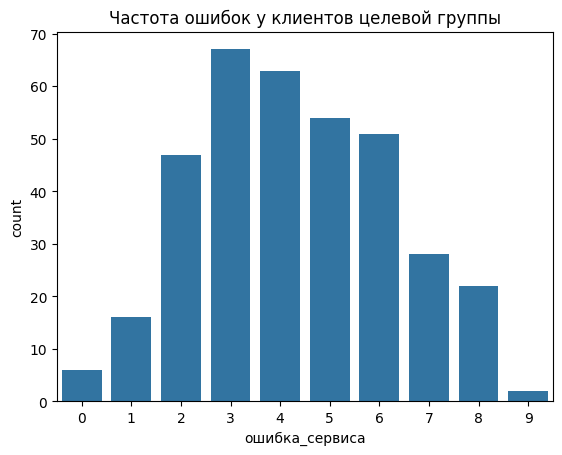

In [93]:
# Распределение ошибок в целевой группе
sns.countplot(x=tech_group['ошибка_сервиса'])
plt.title('Частота ошибок у клиентов целевой группы')
plt.show()

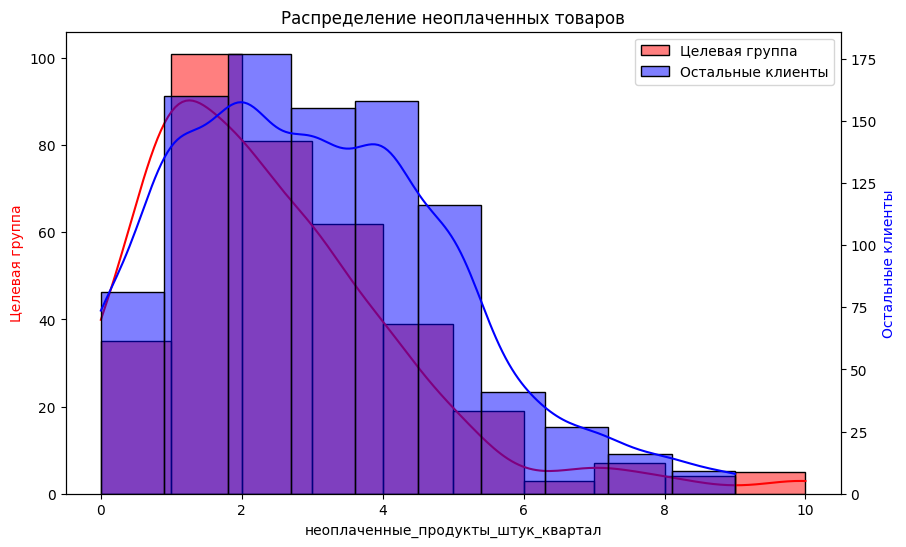

In [94]:
# Визуализация распределения неоплаченных товаров
# Гистограммы

# Создание фигуры и первой оси
fig, ax1 = plt.subplots(figsize=(10, 6))

# Построение первой гистограммы на первой оси
sns.histplot(
    tech_group['неоплаченные_продукты_штук_квартал'],
    kde=True,
    bins=10,
    color='red',
    label='Целевая группа',
    ax=ax1
)
ax1.set_ylabel('Целевая группа', color='red')

# Создание второй оси
ax2 = ax1.twinx()

# Построение второй гистограммы на второй оси
sns.histplot(
    market_df[~market_df.index.isin(tech_group.index)]['неоплаченные_продукты_штук_квартал'],
    kde=True,
    bins=10,
    color='blue',
    label='Остальные клиенты',
    ax=ax2
)
ax2.set_ylabel('Остальные клиенты', color='blue')

# Настройка легенды
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

plt.title('Распределение неоплаченных товаров')
plt.show()

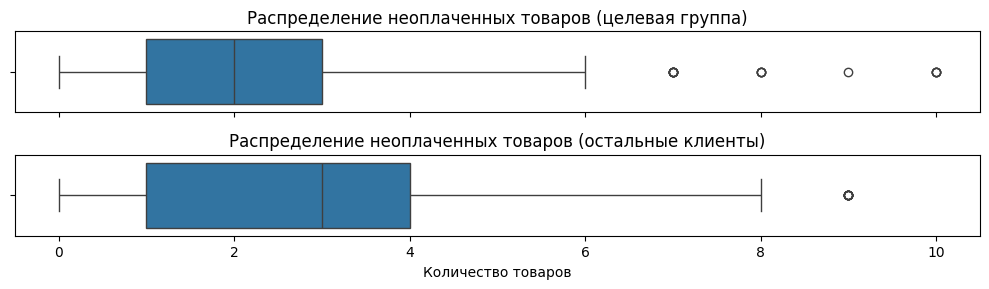

In [95]:
# Визуализация распределения неоплаченных товаров
# Диаграммы размаха

# Создаем фигуру с двумя подграфиками, расположенными вертикально
fig, axes = plt.subplots(2, 1, figsize=(10, 3), sharex=True)

# Первая диаграмма размаха
sns.boxplot(
    x=tech_group['неоплаченные_продукты_штук_квартал'],
    orient='h',
    ax=axes[0]
)
axes[0].set_title('Распределение неоплаченных товаров (целевая группа)')
axes[0].set_xlabel('Количество товаров')

# Вторая диаграмма размаха
sns.boxplot(
    x=market_df[~market_df.index.isin(tech_group.index)]['неоплаченные_продукты_штук_квартал'],
    orient='h',
    ax=axes[1]
)
axes[1].set_title('Распределение неоплаченных товаров (остальные клиенты)')
axes[1].set_xlabel('Количество товаров')

# Убираем пустое пространство между графиками
plt.tight_layout()
plt.show()

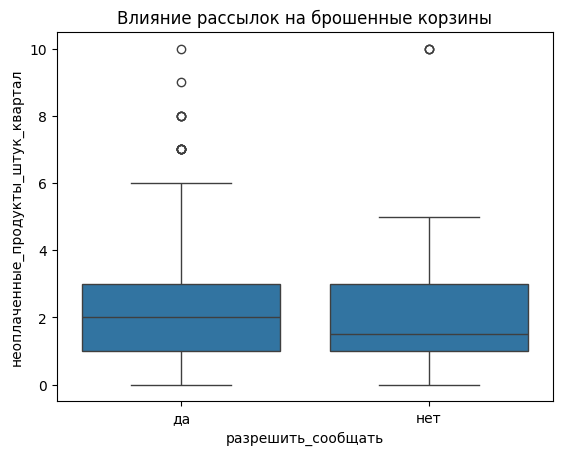

In [96]:
# Сравнение неоплаченных товаров в зависимости от разрешения
sns.boxplot(
    x=tech_group['разрешить_сообщать'],
    y=tech_group['неоплаченные_продукты_штук_квартал']
)
plt.title('Влияние рассылок на брошенные корзины')
plt.show()

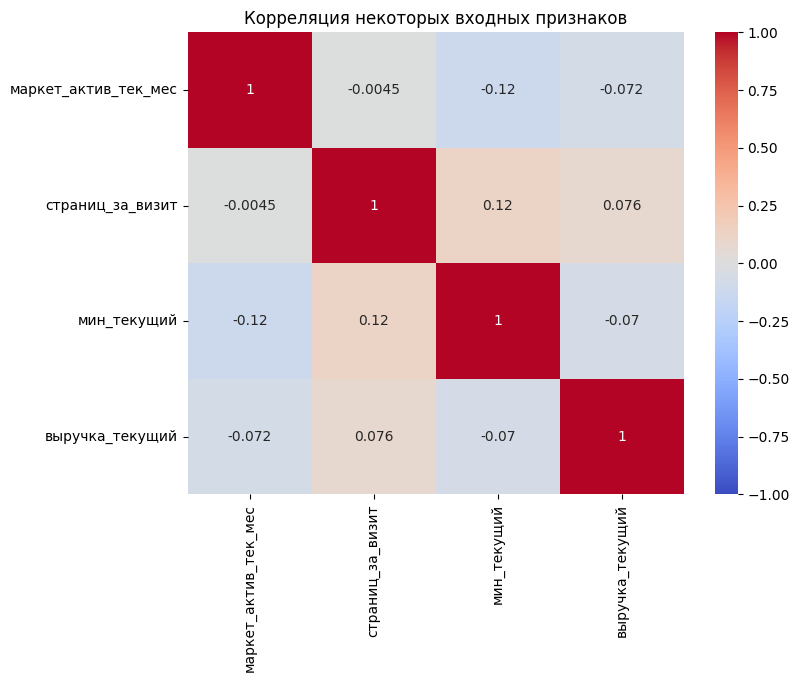

In [97]:
# матрица корреляции некоторых входных признаков

corr_matrix = tech_group[[
    'маркет_актив_тек_мес', 
    'страниц_за_визит', 
    'мин_текущий', 
    'выручка_текущий'
]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Корреляция некоторых входных признаков')
plt.show()

**Анализ результатов и рекомендации**

**1. Маркетинговая активность:**
- В группе: маркет_актив_6_мес = 4.45 (выше, чем вне группы: 4.18).
- В группе в текущем месяце: маркет_актив_тек_мес = 4.03 (немного выше, чем вне группы: 4.00).
- Средняя доля акционных покупок для целевой группы: 0.29 (ниже, чем вне группы: 0.33)

*Выводы:*
- Группа получает больше маркетинговых коммуникаций, но это не приводит к росту покупательской активности.
- Клиенты целевой группы меньше реагируют на акции.

*Рекомендация:*
- Снизить частоту рассылок, но повысить их релевантность (например, упоминать брошенные товары).
- Использовать персонализированные предложения (например: "Мы заметили, что вы интересовались роботом-пылесосом. Вот акция на него!")

**2. Неоплаченные товары:**
- В группе: 2.38 товаров за квартал (против 3.02 вне группы).

*Вывод:* Клиенты группы реже добавляют товары в корзину, но чаще завершают покупки.

*Рекомендация:*
- Улучшить процесс оплаты (например, добавить возможность оплаты в один клик).
- Отправлять напоминания о брошенной корзине (74.7% согласны на рассылки).

**3. Ошибки сервиса:**
- В группе: 4.29 ошибок (выше, чем вне группы: 4.14).

*Вывод:* Технические проблемы могут снижать доверие к сайту.

*Рекомендация:*
- Провести аудит сайта для выявления частых ошибок.
- Добавить подсказки при ошибках (например, "Проверьте данные карты. Нужна помощь? Напишите в поддержку").

**4. Поведение на сайте:**
- `страниц_за_визит`: 8.90 (выше, чем вне группы: 7.92).
- Время на сайте: 14.0–14.4 минут (стабильно высокое).

*Вывод:* Клиенты группы тратят много времени на выбор товаров, но не всегда завершают покупки.

*Рекомендация:*
- Добавить интерактивные элементы (например, видеообзоры, отзывы).
- Добавить образовательный контент (например, видеоинструкции по использованию техники, вебинары "Как выбрать технику для дома")
- Персонализировать главную страницу под интересы клиента.

**5. Длительность регистрации:**
- `длительность`: 612 дней (выше, чем вне группы: 599 дней).

*Вывод:* Клиенты зарегистрированы давно, но активность снижается, это признак усталости.

*Рекомендация:* Предложить "реактивационные" акции (например, "Давно не покупали? Вот купон на 500 руб.").

#### **Анализ динамики выручки**
Задача: Проверить, как изменилась выручка и время на сайте у клиентов, покупающих технику.

In [98]:
# Динамика выручки
print("\033[1mДинамика выручки (текущий vs предыдущий):\033[0m")
print(tech_group[['выручка_предыдущий', 'выручка_текущий']].mean())

# Динамика времени на сайте
print("\n\033[1mДинамика времени на сайте (мин):\033[0m")
print(tech_group[['мин_предыдущий', 'мин_текущий']].mean())

Динамика выручки (текущий vs предыдущий):
выручка_предыдущий    9689.103933
выручка_текущий       5132.730337
dtype: float64

Динамика времени на сайте (мин):
мин_предыдущий    14.390449
мин_текущий       13.985955
dtype: float64


In [99]:
# Сравнение динамики выручки
print("\033[1mПадение выручки премиум-клиентов:\033[0m")
print(tech_group[tech_group['тип_сервиса'] == 'премиум'][['выручка_предыдущий', 'выручка_текущий']].mean())

print("\n\033[1mПадение выручки стандарт-клиентов:\033[0m")
print(tech_group[tech_group['тип_сервиса'] == 'стандарт'][['выручка_предыдущий', 'выручка_текущий']].mean())

Падение выручки премиум-клиентов:
выручка_предыдущий    9612.089888
выручка_текущий       5037.973034
dtype: float64

Падение выручки стандарт-клиентов:
выручка_предыдущий    9714.775281
выручка_текущий       5164.316105
dtype: float64


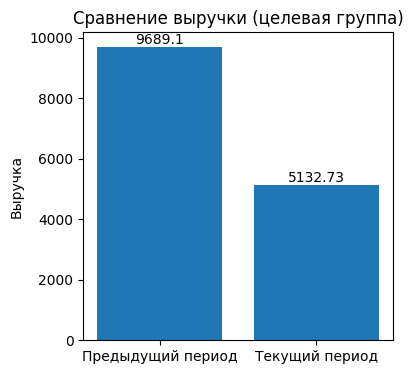

In [100]:
# Создание столбчатой диаграммы
plt.figure(figsize=(4, 4))
bars = plt.bar(['Предыдущий период', 'Текущий период'], [9689.10, 5132.73])
plt.title('Сравнение выручки (целевая группа)')
plt.ylabel('Выручка')

# Добавление подписей значений на столбцах
for bar, value in zip(bars, [9689.10, 5132.73]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2), ha='center', va='bottom')

plt.show()

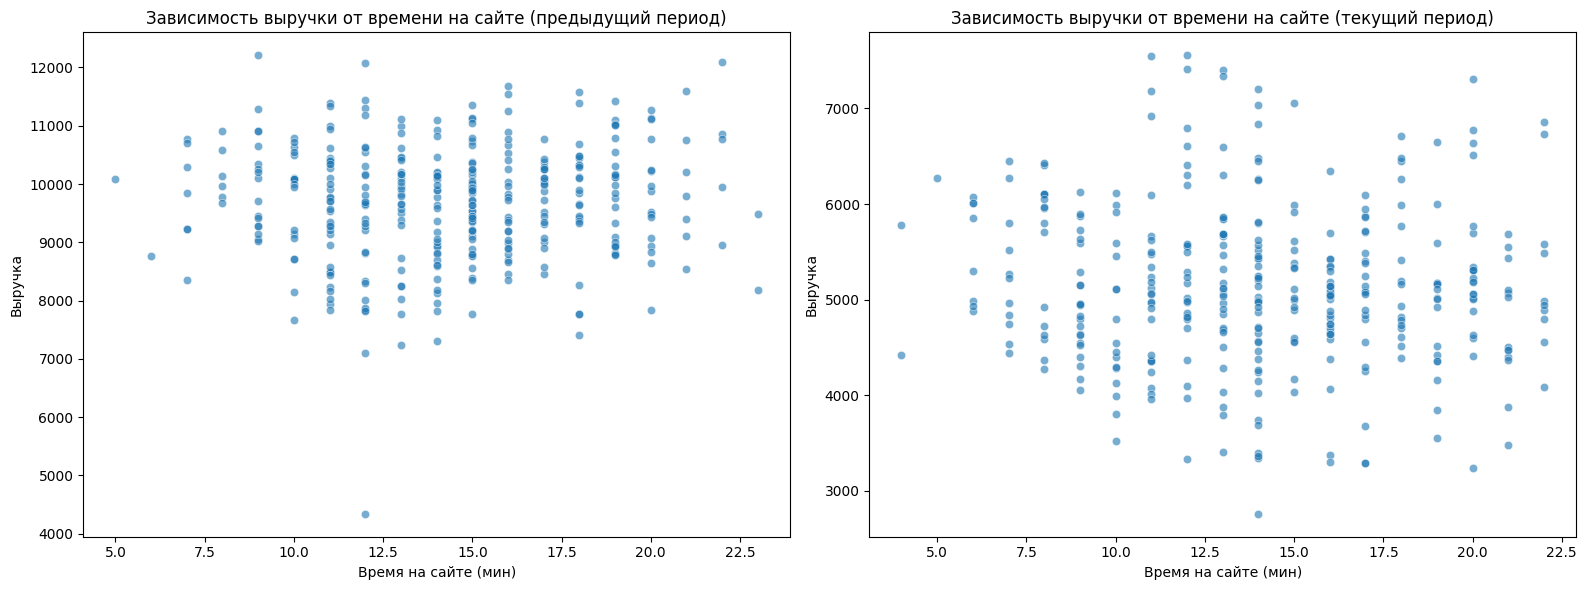

In [101]:
# визуализация корреляции между временем на сайте и выручкой
# диаграммы рассеяния выручка-время для двух периодов

# Создаем фигуру с двумя подграфиками в одной строке
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Первый график
sns.scatterplot(
    x=tech_group['мин_предыдущий'],
    y=tech_group['выручка_предыдущий'],
    alpha=0.6,
    ax=axes[0]
)
axes[0].set_title('Зависимость выручки от времени на сайте (предыдущий период)')
axes[0].set_xlabel('Время на сайте (мин)')
axes[0].set_ylabel('Выручка')

# Второй график
sns.scatterplot(
    x=tech_group['мин_текущий'],
    y=tech_group['выручка_текущий'],
    alpha=0.6,
    ax=axes[1]
)
axes[1].set_title('Зависимость выручки от времени на сайте (текущий период)')
axes[1].set_xlabel('Время на сайте (мин)')
axes[1].set_ylabel('Выручка')

# Показываем графики
plt.tight_layout()
plt.show()

**Анализ результатов и рекомендации**

**1. Выручка:**
- Падение как для премиум-, так и для стандарт-клиентов одинаково, в среднем для всех клиентов целевой группы с 9689 до 5133 (на 47%).

*Вывод:* Критическое снижение, требующее немедленных действий.

*Рекомендация:*
- Запустить краткосрочную акцию (например, "Скидка 20% на первую покупку после перерыва").
- Предложить комплекты товаров (например, "Купите пылесос + фильтры = скидка 15%").
- Предложить бесплатную доставку для группы.

**2. Время на сайте:**
- Стабильное (~14 минут), но выручка падает.

*Вывод:* Клиенты проводят много времени на сайте, но не совершают покупки.

*Рекомендация:*
- Упростить процесс оформления заказа.
- Добавить кнопку "Помощь" на страницах с техникой.
- Добавить быстрые ссылки на популярные категории.
- Внедрить чат-бота с подсказками (например, "Не можете выбрать модель? Ответьте на 3 вопроса!").

#### **Итоговые рекомендации для целевой группы**

**Ключевой инсайт:** Клиенты целевой группы требуют меньше спама, больше персонализации и четкой выгоды от премиум-сервиса.

**1. Персонализация взаимодействия**

*Для премиум-клиентов:*
- Запустить VIP-программу с:
    - Бесплатной доставкой крупногабаритной техники.
    - Расширенной гарантией (3 года вместо 1).
    - Персональным менеджером для консультаций.
Пример акции: "Продлите премиум-сервис — получите комплект аксессуаров в подарок".

*Для стандарт-клиентов:*
- Предложить апселл: "Обновите сервис до премиум — 2 месяца бесплатно + скидка 15% на первую покупку".
- Внедрить программу лояльности: "Каждая покупка техники = баллы на счет для скидок".

**2. Оптимизация маркетинговых коммуникаций**
- Снижение частоты, повышение релевантности :
    - Отправлять не более 3 рассылок в месяц, но с персонализированными предложениями:
        - "Мы заметили, что вы смотрели робот-пылесос. Сейчас он со скидкой 20%!"
        - "Ваша корзина ждет! Оформите заказ за 1 клик — и получите подарок"
- Триггерные рассылки :
    - Напоминания о брошенной корзине (через 1 час и 24 часа).
    - Реактивационные письма: "Давно не виделись! Ваш купон на 500 руб внутри"

**3. Улучшение UX для повышения конверсии**
- Упрощение оплаты:
    - Внедрить оплату в 1 клик (сохранение данных карты).
    - Добавить возможность оплаты через Google Pay/Apple Pay.
- Интерактивные элементы:
    - Чат-бот с подсказками: "Не можете выбрать? Ответьте на 3 вопроса — и мы подберем идеальную модель!".
    - Видеообзоры техники на страницах товаров.
- Персонализация главной страницы:
    - Блок "Рекомендуем для вас" на основе истории просмотров.
    - Быстрые ссылки на популярные категории (например, "Хиты бытовой техники").

**4. Борьба с ошибками сервиса**
- Аудит и исправление:
    - Выявить топ-ошибки через анализ логов (например, сбои на этапе оплаты).
    - Внедрить систему моментальной поддержки: "Ошибка при оплате? Напишите нам — решим проблему за 5 минут!".

**5. Стимулирование повторных покупок**
- Комплекты товаров со скидкой:
    - "Купите пылесос + набор фильтров = скидка 15%".
    - "Техника + аксессуары: экономия до 20%".
- Trade-In программа:
    - "Сдайте старую технику — получите скидку 30% на новую".
 
**6. Образовательный контент**
- Вебинары и инструкции :
    - "Как выбрать холодильник: 5 ключевых параметров".
    - "Обзор новинок бытовой техники 2023".
- Полезные рассылки :
    - Статьи в блоге: "Как продлить срок службы кофемашины".

**7. Аналитика и тесты**
- A/B тесты :
    - Тестирование новых функций (например, чат-бот vs кнопка "Помощь").
    - Оценка эффективности акций через метрики: конверсия, средний чек, retention rate.
- Отслеживать метрики: конверсия, средний чек, retention rate.

## Общий вывод

**Требовалось** разработать персонализированные предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

В распоряжении **четыре датасета**:
- данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении;
- данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом;
- данные о времени (в минутах), которое покупатель провел на сайте в течение периода;
- данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Во время предобработки** обнаружено, что пропуски отсутствуют, также исправлен тип данных в одном из признаков, исправлены грамматические ошибки в наименовании классов категориальных признаков, удалены явные дубликаты. **Во время исследовательского анализа** отобраны клиенты, которые имели выручку за исследуемый период, удален клиент с аномально большой выручкой и обнаружен дисбаланс целевого бинарного признака `покупательская_активность`.

**Перед поиском лучшей модели машинного обучения** датафреймы объединены по `id` клиентов, данные разделены по периодам. Установлено, что мультиколлинеарность между входными признаками отсутствует.

**Для поиска лучшей модели машинного обучения** использовались один общий пайплайн для всех моделей и инструмент подбора гиперпараметров. В качестве метрики использовалась метрика ROC-AUC, так как она менее чувствительна к дисбалансу классов, который наблюдается у целевого признака. **Лучшей моделью** (среди `DecisionTreeClassifier`, `KNeighborsClassifier`, `LogisticRegression`, `SVC`) по метрике ROC-AUC оказалась модель `SVC` с ядром `rbf` (метрика ROC-AUC на тестовой выборке: 0.906).

**Исследовались два сегмента клиентов:**
- группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью.
- группа клиентов, которые покупают преимущественно технику, то есть товары с длинным жизненным циклом.

**Первая группа** для повышения покупательской активности требует персонализированных предложений, меньше навязчивых рассылок, эксклюзивных преимуществ для премиум-сервиса, мотивации для завершения покупок (например, скидки на брошенные товары) и упрощенной навигации для повышения вовлеченности.

**Рекомендации:**
Для повышения удовлетворенности премиум-клиентов необходимо внедрить эксклюзивные предложения и персональное обслуживание. В топ-категориях ("Детские товары", "Косметика") — запустить сезонные акции и персонализированные рекомендации. Снизить частоту рассылок, но повысить их релевантность через триггерные письма о брошенных корзинах с временными скидками. Упростить навигацию сайта (быстрые ссылки, чат-бот) и добавить интерактивные элементы (видео, истории клиентов). Для восстановления выручки срочно ввести акции "20% скидка за возвращение" и бесплатную доставку, а также запустить программу лояльности. Контролировать результаты через A/B-тесты и метрики: конверсию, средний чек, retention rate.

**Вторая группа** для повышения покупательской активности требует меньше спама, больше персонализации и четкой выгоды от премиум-сервиса.

**Рекомендации:**
Для повышения лояльности и конверсии необходимо внедрить персонализированные программы: VIP-клиентам — бесплатную доставку, расширенную гарантию и персонального менеджера, а стандартным — апселл с пробным премиум-периодом и накопительными баллами. Оптимизировать коммуникации через релевантные рассылки (не более 3 в месяц) и триггерные письма, улучшить UX с помощью оплаты в 1 клик, чат-бота и персонализированных рекомендаций. Внедрить систему моментальной поддержки при ошибках, стимулировать повторные покупки через комплекты со скидкой и trade-in, а также подкреплять стратегию A/B-тестами и аналитикой ключевых метрик.